In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet


2024-11-13 11:28:23.014631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 11:28:23.828725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-13 11:28:23.828795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-11-13 11:28:23.828801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Augment fns

In [12]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# Load Data

In [2]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)


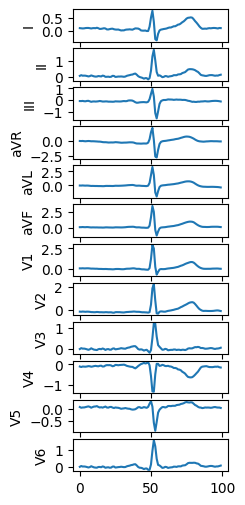

In [4]:
# get a random sample of the data
sample = np.random.randint(0, X_train.shape[0])
sample = X_train[sample]
dv.plot_12_lead_ecg(sample)

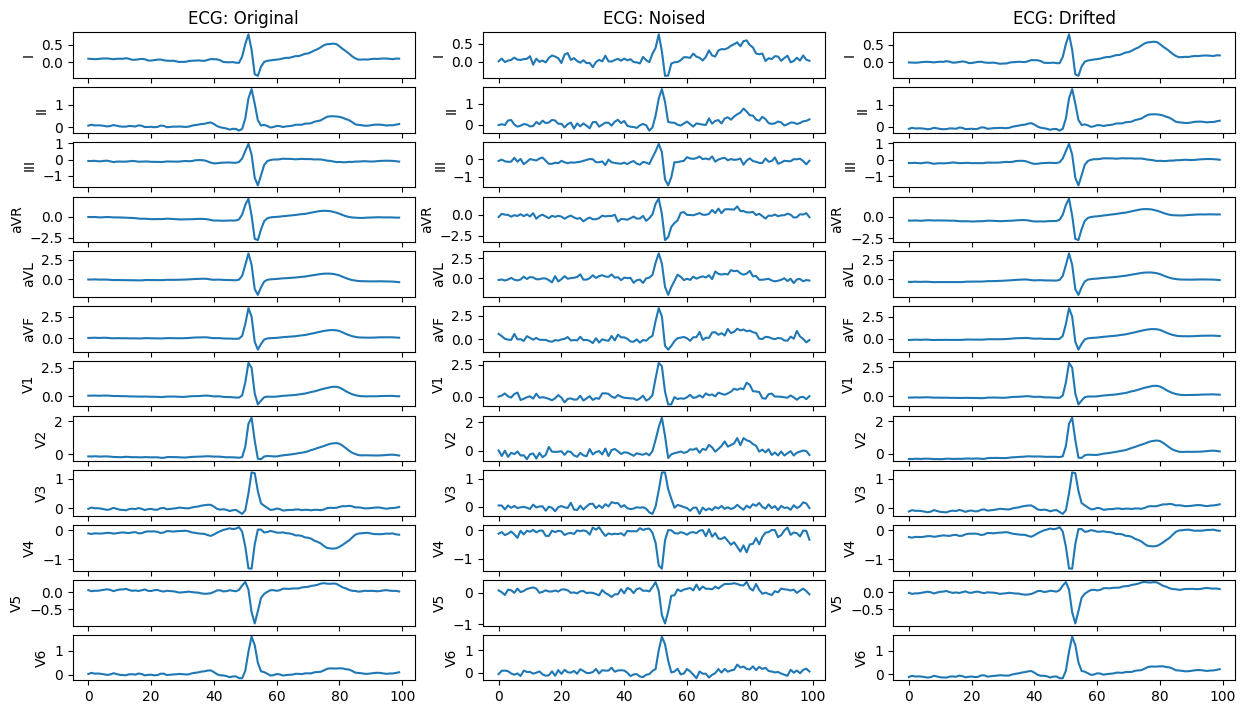

In [5]:
noised_sample = da.add_random_noise(sample, (0.2, 0.4))
drifted_sample, _ = da.add_random_baseline_drift(sample, strength_range=(2 ,3), drift_wavelength_range=(300,500))

dv.plot_12_lead_ecgs([sample, noised_sample, drifted_sample], ['Original', 'Noised', 'Drifted'])

In [13]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_resampled_per_fold.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


In [7]:
# deep smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_deep_resampled_per_fold.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print(X_train_resampled_deep.shape, Y_train_resampled_deep.shape)
print(folds_train_resampled_deep.shape)
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)
Y_train_resampled = np.where(Y_train_resampled == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


# Resnet K-Fold

In [11]:
def k_fold_finetune_resnet(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        if weights_path:
            fine_tuned_model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in fine_tuned_model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
        history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train.shape[0]//batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        
        
        print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc},Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            fine_tuned_model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
        
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")
    
    # load best model
    fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
    fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    fine_tuned_model.load_weights(f'model-weights/fine-tuned/{name}')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = fine_tuned_model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    

# No Pre-training


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.8672199249267578, Val Recall: 0.9457013607025146, Val AUC: 0.9936155011578238, Val F1 Score: 0.9047619105502384
Test Accuracy: 0.9680407643318176, Test Precision: 0.9281663298606873, Test Recall: 0.9406130313873291, Test AUC: 0.9967279646676357,Test F1 Score: 0.9343482310066521

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9506173133850098, Val Precision: 0.9105058312416077, Val Recall: 0.8897338509559631, Val AUC: 0.9780430283486548, Val F1 Score: 0.9000000028435647
Test Accuracy: 0.9647985100746155, Test Precision: 0.9207547307014465, Test Recall: 0.9348658919334412, Test AUC: 0.994328940192905,Test F1 Score: 0.9277566567964479

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.920604944229126, Val Precision: 0.8504983186721802, Val Recall: 0.8677965998649597, Val AUC: 0.96187218162

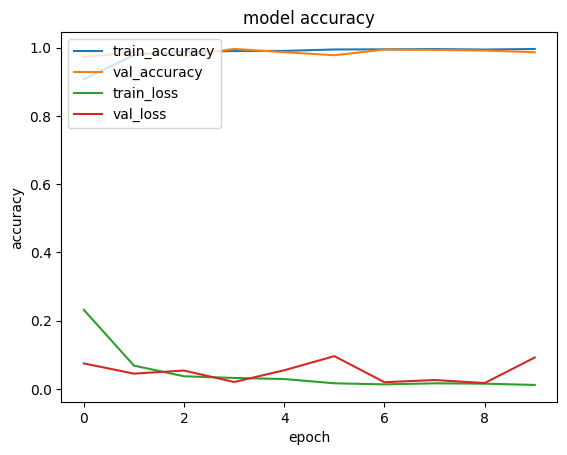

K-Fold Results:
Acuracy: 0.9550228416919708 	 +/- 0.023891085101799932
Precision: 0.9254277944564819 	 +/- 0.04953458128465773
Recall: 0.9041850566864014 	 +/- 0.047655296556985395
AUC: 0.9836412838763906 	 +/- 0.015485853220139878
F1: 0.9135116827074491 	 +/- 0.03563197038888848


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9555349946022034, Test Precision: 0.8561872839927673, Test Recall: 0.9808428883552551, Test AUC: 0.9837357843171675, Test F1 Score: 0.9142857000885569


In [16]:
# no smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8863636255264282, Val Recall: 0.8823529481887817, Val AUC: 0.9610596241252983, Val F1 Score: 0.8843537396246153
Test Accuracy: 0.962945818901062, Test Precision: 0.88908451795578, Test Recall: 0.967432975769043, Test AUC: 0.991904170089665,Test F1 Score: 0.926605522246305

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9382715821266174, Val Precision: 0.875, Val Recall: 0.8783270120620728, Val AUC: 0.9755691389517256, Val F1 Score: 0.8766603494580797
Test Accuracy: 0.9462714195251465, Test Precision: 0.862500011920929, Test Recall: 0.9252873659133911, Test AUC: 0.9888433659366611,Test F1 Score: 0.8927911383929052

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9404537081718445, Val Precision: 0.9027777910232544, Val Recall: 0.8813559412956238, Val AUC: 0.9639269609258724, Val F1 Scor

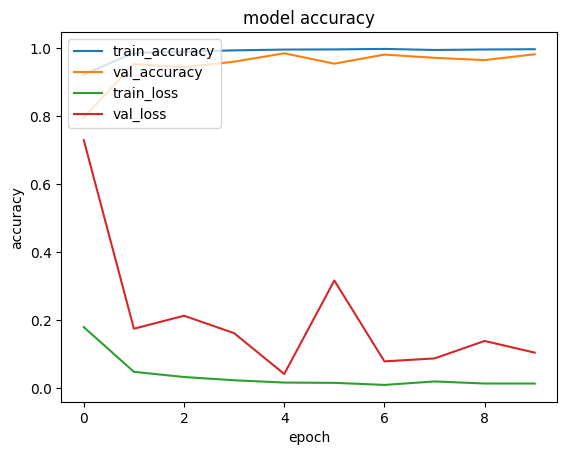

K-Fold Results:
Acuracy: 0.9552104622125626 	 +/- 0.019592927651866664
Precision: 0.9102562516927719 	 +/- 0.03175874188654669
Recall: 0.9190751761198044 	 +/- 0.04989957842173844
AUC: 0.979487584388123 	 +/- 0.01601111954864235
F1: 0.9138772091910907 	 +/- 0.031199855146125978


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9481241106987, Test Precision: 0.8740875720977783, Test Recall: 0.9176245331764221, Test AUC: 0.991569476919044, Test F1 Score: 0.8953270985226575


In [17]:
# smote
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8662477731704712, Val Precision: 0.7117646932601929, Val Recall: 0.5475113391876221, Val AUC: 0.8599058539773907, Val F1 Score: 0.6189258436624848
Test Accuracy: 0.8522464036941528, Test Precision: 0.8103975653648376, Test Recall: 0.507662832736969, Test AUC: 0.8362554621691393,Test F1 Score: 0.6242638414275146

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7758784294128418, Val Precision: 0.8292682766914368, Val Recall: 0.1292775720357895, Val AUC: 0.7105356885017086, Val F1 Score: 0.22368421817135178
Test Accuracy: 0.7698008418083191, Test Precision: 0.8205128312110901, Test Recall: 0.061302680522203445, Test AUC: 0.7856418970315291,Test F1 Score: 0.11408199399267382

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7684310078620911, Val Precision: 0.6068376302719116, Val Recall: 0.4813559353351593, Val AUC: 0.722029

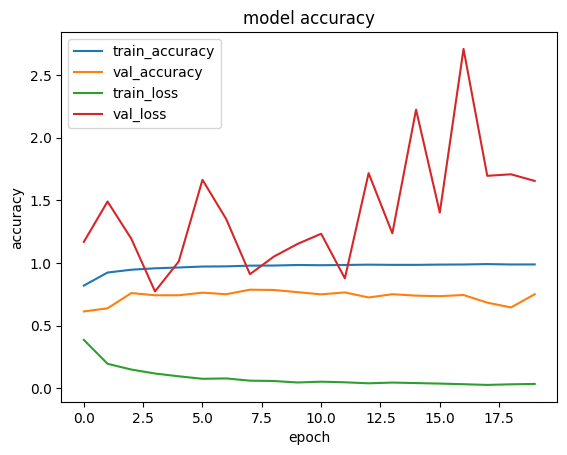

K-Fold Results:
Acuracy: 0.7791413813829422 	 +/- 0.04495708351753779
Precision: 0.6014806283637881 	 +/- 0.2133020002128203
Recall: 0.3084369017742574 	 +/- 0.20501959627310629
AUC: 0.7134087697044207 	 +/- 0.1201388293450086
F1: 0.37765609044798065 	 +/- 0.19935239550485553


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.8615099787712097, Test Precision: 0.7107750177383423, Test Recall: 0.7203065156936646, Test AUC: 0.9086685531190829, Test F1 Score: 0.7155090251795675


In [16]:
# deep smote
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, batch_size=32, epochs=20, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_no_pretrain__deep_smote_brugada.h5")

# Transfer Learning


Training on fold 1


2024-06-03 17:22:51.990682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9829443693161011, Val Precision: 0.9764150977134705, Val Recall: 0.9366515874862671, Val AUC: 0.9988447097333205, Val F1 Score: 0.9561200959635071
Test Accuracy: 0.9601667523384094, Test Precision: 0.9113207459449768, Test Recall: 0.9252873659133911, Test AUC: 0.9863302415174005,Test F1 Score: 0.9182509508404928

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9477682709693909, Val Precision: 0.9561403393745422, Val Recall: 0.8288973569869995, Val AUC: 0.944664773547673, Val F1 Score: 0.8879837124242884
Test Accuracy: 0.9680407643318176, Test Precision: 0.9557344317436218, Test Recall: 0.9099617004394531, Test AUC: 0.9817071458162183,Test F1 Score: 0.9322865751566252

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.8979206085205078, Val Precision: 0.8912134170532227, Val Recall: 0.7220339179039001, Val AUC: 0.9313526001288402, Val F1 Score

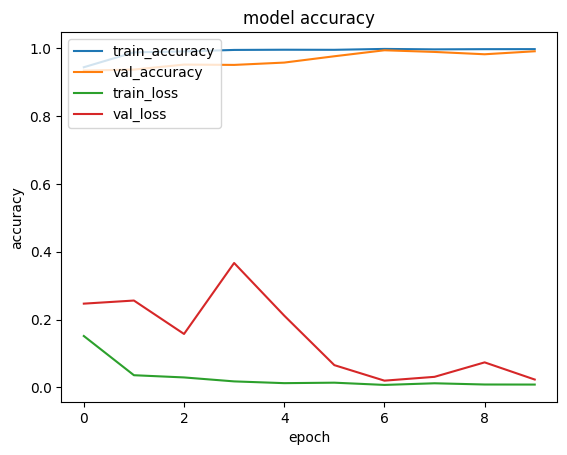

K-Fold Results:
Acuracy: 0.9501484110951424 	 +/- 0.031210351991314396
Precision: 0.9347561597824097 	 +/- 0.04342580673155319
Recall: 0.8724537938833237 	 +/- 0.0870048433371881
AUC: 0.9775633687105822 	 +/- 0.024410407436563555
F1: 0.9008017133838784 	 +/- 0.05898993567311808


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9745252728462219, Test Precision: 0.9533980488777161, Test Recall: 0.9406130313873291, Test AUC: 0.9962856079596121, Test F1 Score: 0.9469623892043331


In [7]:
# ptbxl No smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_no_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.96499103307724, Val Precision: 0.9333333373069763, Val Recall: 0.8868778347969055, Val AUC: 0.9964986597619494, Val F1 Score: 0.9095127664531664
Test Accuracy: 0.960629940032959, Test Precision: 0.924271821975708, Test Recall: 0.9118773937225342, Test AUC: 0.9852775963881224,Test F1 Score: 0.918032775232684

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9449192881584167, Val Precision: 0.9324894547462463, Val Recall: 0.8403041958808899, Val AUC: 0.9850700293593877, Val F1 Score: 0.8840000088682174
Test Accuracy: 0.9536822438240051, Test Precision: 0.9137254953384399, Test Recall: 0.8927202820777893, Test AUC: 0.9866596685367355,Test F1 Score: 0.9031007652019343

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9224952459335327, Val Precision: 0.9419087171554565, Val Recall: 0.7694915533065796, Val AUC: 0.94694893040406

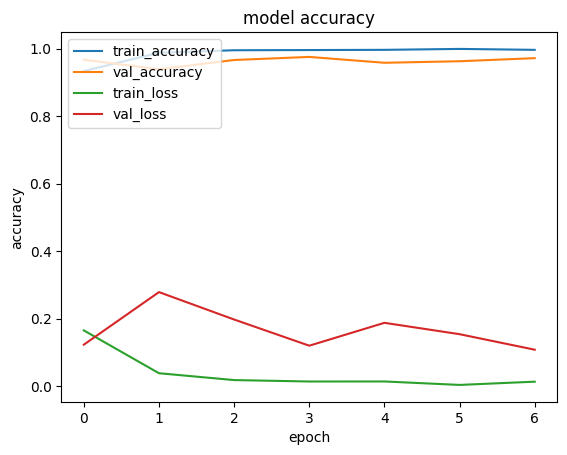

K-Fold Results:
Acuracy: 0.9595411941409111 	 +/- 0.016368863346771977
Precision: 0.9525367915630341 	 +/- 0.03345428434944915
Recall: 0.8824830651283264 	 +/- 0.056445426095819894
AUC: 0.9872656296493568 	 +/- 0.01622214256944527
F1: 0.9148543805047443 	 +/- 0.03325976373920273


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9481241106987, Test Precision: 0.8416666388511658, Test Recall: 0.967432975769043, Test AUC: 0.9812484055264161, Test F1 Score: 0.9001782482831954


In [20]:
# ptbxl No smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=7, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_no_smote_transfer2.h5")


Training on fold 1
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9838420152664185, Val Precision: 0.9356223344802856, Val Recall: 0.9864253401756287, Val AUC: 0.9945909107031563, Val F1 Score: 0.9603524321849648
Test Accuracy: 0.9638721346855164, Test Precision: 0.8950178027153015, Test Recall: 0.9636015295982361, Test AUC: 0.9895566368719529,Test F1 Score: 0.9280442839692022

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9553655982017517, Val Precision: 0.9615384340286255, Val Recall: 0.855513334274292, Val AUC: 0.9633344563700246, Val F1 Score: 0.9054325981003917
Test Accuracy: 0.958314061164856, Test Precision: 0.9302788972854614, Test Recall: 0.8946360349655151, Test AUC: 0.986828770505808,Test F1 Score: 0.9121093913709046

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9376181364059448, Val Precision: 0.8989546895027161, Val Recall: 0.8745762705802917, Val AUC: 0.970935424395

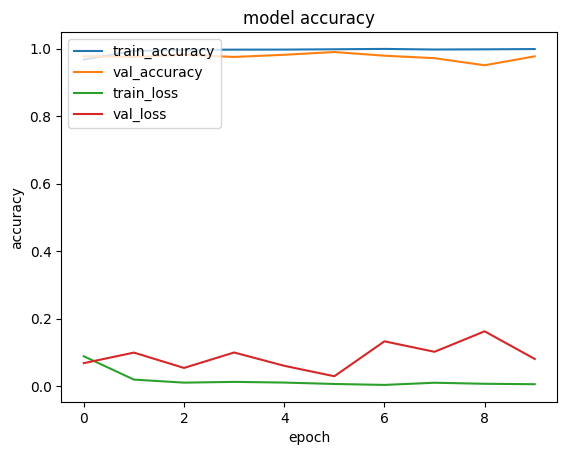

K-Fold Results:
Acuracy: 0.9564328044652939 	 +/- 0.018408873824631366
Precision: 0.9068304300308228 	 +/- 0.0738103798476
Recall: 0.9292140752077103 	 +/- 0.060370699119417615
AUC: 0.9857593748566027 	 +/- 0.012768943091836168
F1: 0.9138929166596237 	 +/- 0.0362254050245637


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9597035646438599, Test Precision: 0.8863232731819153, Test Recall: 0.9559386968612671, Test AUC: 0.989928193101576, Test F1 Score: 0.9198156706708471


In [8]:
# ptbxl SMOTE
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8213644623756409, Val Precision: 0.7115384340286255, Val Recall: 0.16742081940174103, Val AUC: 0.849432235638678, Val F1 Score: 0.271062275517284
Test Accuracy: 0.7721167206764221, Test Precision: 0.720588207244873, Test Recall: 0.09386973083019257, Test AUC: 0.8463957290342816,Test F1 Score: 0.16610169265058594

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7663817405700684, Val Precision: 0.6734693646430969, Val Recall: 0.12547528743743896, Val AUC: 0.7223131347162729, Val F1 Score: 0.21153846361908876
Test Accuracy: 0.8360351920127869, Test Precision: 0.942105233669281, Test Recall: 0.34291186928749084, Test AUC: 0.8584727693168279,Test F1 Score: 0.5028089758489841

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7948960065841675, Val Precision: 0.6666666865348816, Val Recall: 0.5288135409355164, Val AUC: 0.7793811

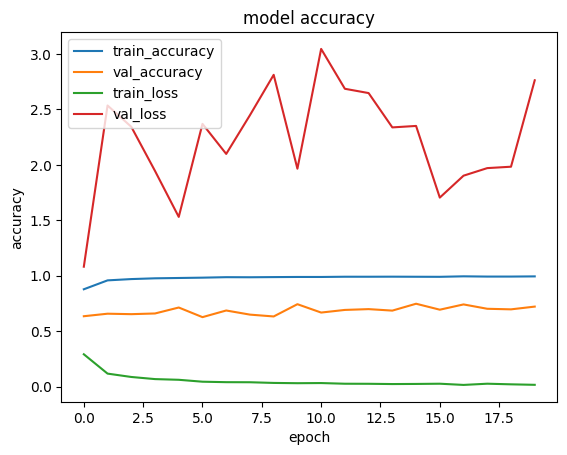

K-Fold Results:
Acuracy: 0.7763475254178047 	 +/- 0.0339385008440797
Precision: 0.5967136211693287 	 +/- 0.0959815351051665
Recall: 0.3744742553681135 	 +/- 0.19811688789530388
AUC: 0.7382874049545779 	 +/- 0.07379841675127746
F1: 0.4275611676715465 	 +/- 0.14689981306038993


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.7336729764938354, Test Precision: 0.4626234173774719, Test Recall: 0.6283524632453918, Test AUC: 0.7655591365384299, Test F1 Score: 0.5329000741944422


In [9]:
# ptbxl Deep SMOTE
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=20, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_deep_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.9234449863433838, Val Recall: 0.8733031749725342, Val AUC: 0.9406292278303344, Val F1 Score: 0.8976744274450934
Test Accuracy: 0.9615562558174133, Test Precision: 0.8912655711174011, Test Recall: 0.9578543901443481, Test AUC: 0.9929375059975611,Test F1 Score: 0.9233610127671623

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9610636234283447, Val Precision: 0.9586777091026306, Val Recall: 0.8821292519569397, Val AUC: 0.9908215815565288, Val F1 Score: 0.9188118779295829
Test Accuracy: 0.9689671397209167, Test Precision: 0.9417475461959839, Test Recall: 0.9291187524795532, Test AUC: 0.9950591798378962,Test F1 Score: 0.9353905256529962

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9499054551124573, Val Precision: 0.8954248428344727, Val Recall: 0.9288135766983032, Val AUC: 0.962374214

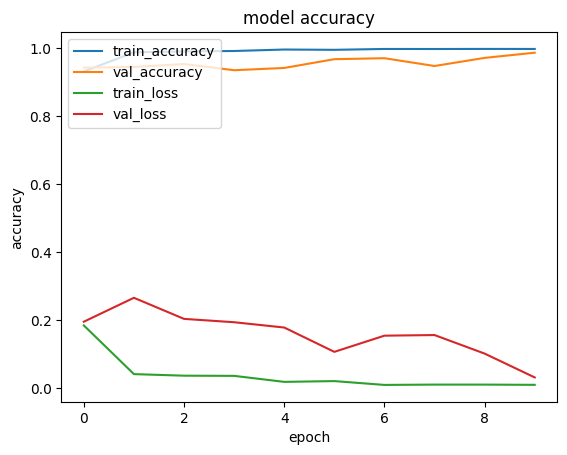

K-Fold Results:
Acuracy: 0.9591707587242126 	 +/- 0.014332292787842142
Precision: 0.898608610033989 	 +/- 0.06643109508922188
Recall: 0.947079986333847 	 +/- 0.04507200232985468
AUC: 0.9841868106154232 	 +/- 0.019965639683247233
F1: 0.9194102083155364 	 +/- 0.030885079498915145


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9578508734703064, Test Precision: 0.8882882595062256, Test Recall: 0.9444444179534912, Test AUC: 0.987406876891426, Test F1 Score: 0.9155060075505385


In [11]:
# norm+rbbb no smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_no_smote_transfer_rbbb.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9614003300666809, Val Precision: 0.9009009003639221, Val Recall: 0.9049773812294006, Val AUC: 0.9904789894250403, Val F1 Score: 0.902934539795471
Test Accuracy: 0.962945818901062, Test Precision: 0.8946428298950195, Test Recall: 0.959770143032074, Test AUC: 0.9967513697844622,Test F1 Score: 0.9260628450583217

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9686609506607056, Val Precision: 0.9791666865348816, Val Recall: 0.8935361504554749, Val AUC: 0.9928526736294941, Val F1 Score: 0.9343936629547875
Test Accuracy: 0.9610931277275085, Test Precision: 0.9101123809814453, Test Recall: 0.931034505367279, Test AUC: 0.9849540206479941,Test F1 Score: 0.9204545674637761

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.95652174949646, Val Precision: 0.9249146580696106, Val Recall: 0.9186440706253052, Val AUC: 0.986076371148677

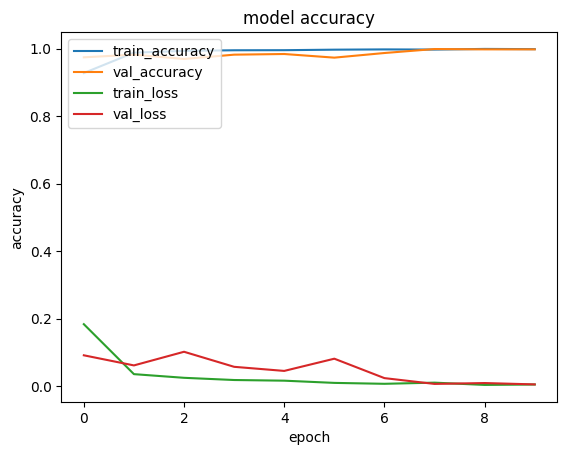

K-Fold Results:
Acuracy: 0.9730071276426315 	 +/- 0.013481210339315068
Precision: 0.9337734878063202 	 +/- 0.03962843710514402
Recall: 0.9601814895868301 	 +/- 0.043080973378465476
AUC: 0.9952325085059057 	 +/- 0.00476927716886425
F1: 0.945884831631617 	 +/- 0.029546922772200897


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.9735988974571228, Test Precision: 0.9622266292572021, Test Recall: 0.9272030591964722, Test AUC: 0.9956419672468796, Test F1 Score: 0.9443902355718301


In [9]:
# norm+rbbb smote freeze 8
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_smote_transfer_rbbb_freeze8.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.979353666305542, Val Precision: 0.9852941036224365, Val Recall: 0.9095022678375244, Val AUC: 0.9788703490699406, Val F1 Score: 0.9458823493957519
Test Accuracy: 0.9833256006240845, Test Precision: 0.9783464670181274, Test Recall: 0.9521072506904602, Test AUC: 0.9984096223116298,Test F1 Score: 0.9650485338141298

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9325736165046692, Val Precision: 0.9948453903198242, Val Recall: 0.73384028673172, Val AUC: 0.9414015497906338, Val F1 Score: 0.8446389487430936
Test Accuracy: 0.966651201248169, Test Precision: 0.9360465407371521, Test Recall: 0.9252873659133911, Test AUC: 0.995453556056425,Test F1 Score: 0.930635857388515

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9489603042602539, Val Precision: 0.8976897597312927, Val Recall: 0.9220339059829712, Val AUC: 0.990852344669791

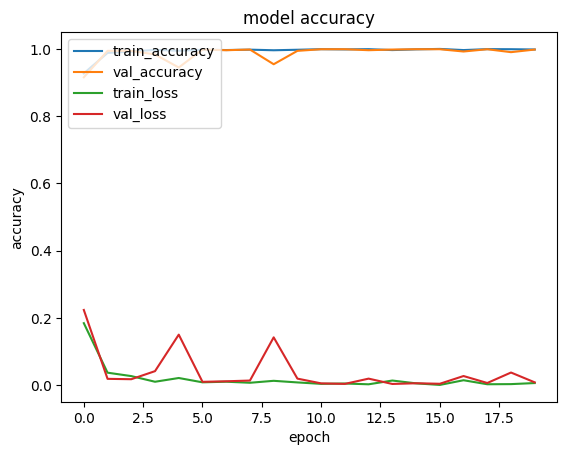

K-Fold Results:
Acuracy: 0.9695446640253067 	 +/- 0.019719098344718227
Precision: 0.95297010242939 	 +/- 0.03992948480906574
Recall: 0.929270550608635 	 +/- 0.0791867777814087
AUC: 0.9870210012719451 	 +/- 0.01834422903141645
F1: 0.9381546314865583 	 +/- 0.04340083851317623


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.983788788318634, Test Precision: 0.976516604423523, Test Recall: 0.9559386968612671, Test AUC: 0.9953400412398159, Test F1 Score: 0.9661180878806175


In [14]:
# norm+rbbb smoote freeze 8 (20 epochs, results not saved)
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_smote_transfer_rbbb.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.6157989501953125, Val Precision: 0.25298330187797546, Val Recall: 0.479638010263443, Val AUC: 0.5885798543726217, Val F1 Score: 0.3312500074232229
Test Accuracy: 0.6813339591026306, Test Precision: 0.3669871687889099, Test Recall: 0.43869730830192566, Test AUC: 0.653866408274177,Test F1 Score: 0.3996509494892204

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.6020892858505249, Val Precision: 0.36505189538002014, Val Recall: 0.802281379699707, Val AUC: 0.7002671222986956, Val F1 Score: 0.5017835857843986
Test Accuracy: 0.4844835698604584, Test Precision: 0.24808184802532196, Test Recall: 0.5574712753295898, Test AUC: 0.5112549355540108,Test F1 Score: 0.343362840252724

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7117202281951904, Val Precision: 0.4695121943950653, Val Recall: 0.26101693511009216, Val AUC: 0.70753937

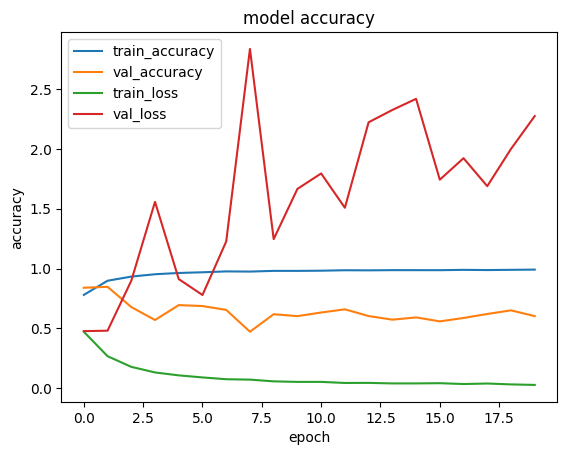

K-Fold Results:
Acuracy: 0.6864400282502174 	 +/- 0.07599543342428512
Precision: 0.406335711479187 	 +/- 0.07569456959914894
Recall: 0.3771863607689738 	 +/- 0.22214534643407072
AUC: 0.698605687586288 	 +/- 0.06209730497890414
F1: 0.34152904805177997 	 +/- 0.13156961377284593


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.4844835698604584, Test Precision: 0.24808184802532196, Test Recall: 0.5574712753295898, Test AUC: 0.5112549355540108, Test F1 Score: 0.343362840252724


In [15]:
# norm+rbbb deep smote
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=20, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_deep_smote_transfer_rbbb.h5")

# SimCLR


Training on fold 1


68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9533213376998901, Val Precision: 0.9941520690917969, Val Recall: 0.7692307829856873, Val AUC: 0.9983126681631392, Val F1 Score: 0.8673469560094386
Test Accuracy: 0.9587771892547607, Test Precision: 0.9253438115119934, Test Recall: 0.9022988677024841, Test AUC: 0.9909469008114553,Test F1 Score: 0.9136760515153094

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9515669345855713, Val Precision: 0.9380165338516235, Val Recall: 0.8631178736686707, Val AUC: 0.9803388362131202, Val F1 Score: 0.8990099048506991
Test Accuracy: 0.9592403769493103, Test Precision: 0.8767361044883728, Test Recall: 0.967432975769043, Test AUC: 0.983347844505766,Test F1 Score: 0.9198542884266909

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9319470524787903, Val Precision: 0.8562300205230713, Val Recall: 0.9084745645523071, Val AUC: 0.951027389652798, Val F1 Score: 

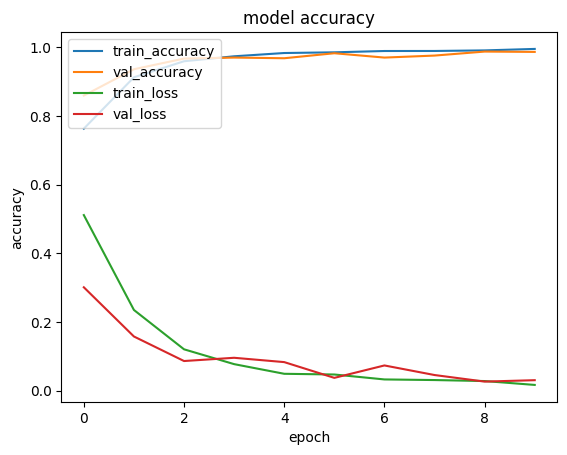

K-Fold Results:
Acuracy: 0.9523432084492275 	 +/- 0.021904541172847767
Precision: 0.9275333285331726 	 +/- 0.038042086168838835
Recall: 0.8791363835334778 	 +/- 0.0902178555994823
AUC: 0.9846635770395592 	 +/- 0.015730809577934227
F1: 0.8994340286362966 	 +/- 0.04796246312624626


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9592403769493103, Test Precision: 0.8793706297874451, Test Recall: 0.9636015295982361, Test AUC: 0.9877743372256043, Test F1 Score: 0.919561242020496


In [18]:
# PTB-XL
# No SMOTE
k_fold_finetune_resnet(7, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_ptbxl_SimCLR_no_smote_brugada.h5")


Training on fold 1


2024-09-11 11:51:00.867602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-11 11:51:00.920397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-11 11:51:00.920603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-11 11:51:00.921060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.958707332611084, Val Precision: 0.9781420826911926, Val Recall: 0.8099547624588013, Val AUC: 0.9793010493886589, Val F1 Score: 0.8861386231802723
Test Accuracy: 0.9601667523384094, Test Precision: 0.9067164063453674, Test Recall: 0.931034505367279, Test AUC: 0.9860774662556726,Test F1 Score: 0.9187145608361466

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9487179517745972, Val Precision: 0.9163346886634827, Val Recall: 0.874524712562561, Val AUC: 0.9849737690715694, Val F1 Score: 0.8949416460788795
Test Accuracy: 0.9430291652679443, Test Precision: 0.8660550713539124, Test Recall: 0.9042145609855652, Test AUC: 0.980591891999429,Test F1 Score: 0.8847235379603782

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9300566911697388, Val Precision: 0.8318318128585815, Val Recall: 0.9389830231666565, Val AUC: 0.9771597396539085, Val F1 Score: 0

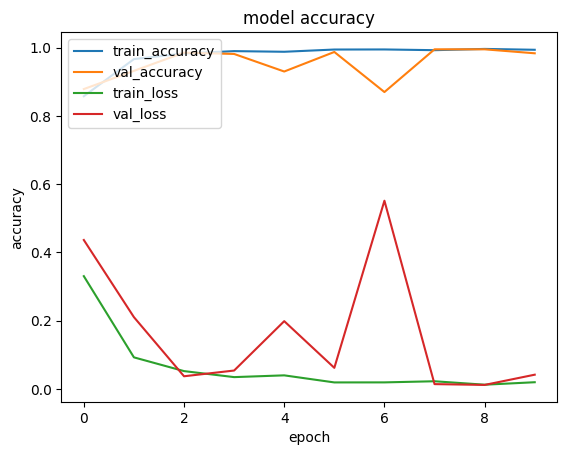

K-Fold Results:
Acuracy: 0.9490406215190887 	 +/- 0.02111722345445484
Precision: 0.8844001218676567 	 +/- 0.056494732286542386
Recall: 0.9301455840468407 	 +/- 0.06495580657041858
AUC: 0.9844114746033173 	 +/- 0.008954848318374684
F1: 0.9037795005478092 	 +/- 0.033251795417032784


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9245020747184753, Test Precision: 0.7871999740600586, Test Recall: 0.9425287246704102, Test AUC: 0.9765316893579274, Test F1 Score: 0.8578901282680529


In [9]:
# BARD
# NO SMOTE
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7, batch_size=32, epochs=10, weights_path='models/simclr-bard_epoch_3.h5', learning_rate=0.0003, num_classes=1, name="resnet10_bard_SimCLR_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.9004524946212769, Val Recall: 0.9004524946212769, Val AUC: 0.9936712388461285, Val F1 Score: 0.9004524946212769
Test Accuracy: 0.9495136737823486, Test Precision: 0.8494077920913696, Test Recall: 0.961685836315155, Test AUC: 0.9833490147616072,Test F1 Score: 0.9020664973888827

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9278252720832825, Val Precision: 0.8303886651992798, Val Recall: 0.8935361504554749, Val AUC: 0.9739615921451605, Val F1 Score: 0.8608058594506818
Test Accuracy: 0.9550718069076538, Test Precision: 0.867012083530426, Test Recall: 0.961685836315155, Test AUC: 0.9863665194484819,Test F1 Score: 0.911898276469533

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9395084977149963, Val Precision: 0.8888888955116272, Val Recall: 0.8949152827262878, Val AUC: 0.9619832507719

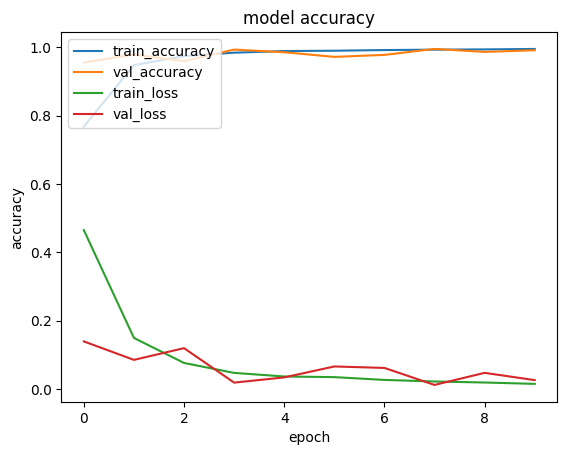

K-Fold Results:
Acuracy: 0.9540170356631279 	 +/- 0.02070510891786806
Precision: 0.9053485244512558 	 +/- 0.042582010462747524
Recall: 0.9131535887718201 	 +/- 0.0674687719816852
AUC: 0.9856975296430306 	 +/- 0.013839340507715701
F1: 0.907859245666982 	 +/- 0.0450160110654207


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.966651201248169, Test Precision: 0.8892733454704285, Test Recall: 0.984674334526062, Test AUC: 0.9889481038344603, Test F1 Score: 0.9345454507721357


In [15]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1


2024-11-13 11:47:05.326592: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x308d6690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-13 11:47:05.326611: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-11-13 11:47:05.338074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 11:47:05.464711: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9640933275222778, Val Precision: 0.9689119458198547, Val Recall: 0.8461538553237915, Val AUC: 0.9944515664823945, Val F1 Score: 0.9033816602220947
Test Accuracy: 0.9509031772613525, Test Precision: 0.8768116235733032, Test Recall: 0.9272030591964722, Test AUC: 0.9832594901897452,Test F1 Score: 0.9013035508868344

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9335232377052307, Val Precision: 0.8509091138839722, Val Recall: 0.8897338509559631, Val AUC: 0.9729075419935507, Val F1 Score: 0.8698884929329915
Test Accuracy: 0.9458082318305969, Test Precision: 0.8292682766914368, Test Recall: 0.977011501789093, Test AUC: 0.9859382058105542,Test F1 Score: 0.8970976191494656

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9470699429512024, Val Precision: 0.8918032646179199, Val Recall: 0.9220339059829712, Val AUC: 0.9546215874003154, Val F1 Score

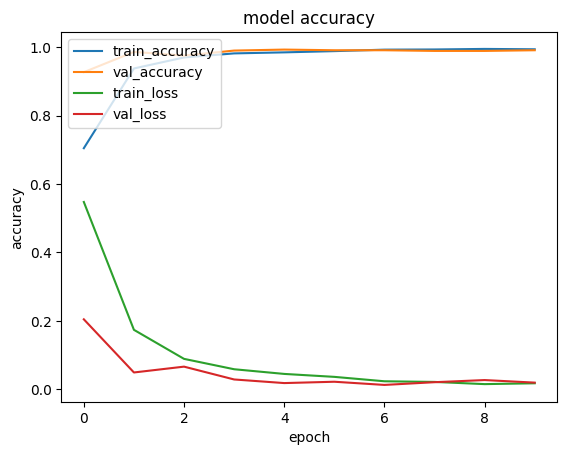

K-Fold Results:
Acuracy: 0.9556569680571556 	 +/- 0.019381186501312733
Precision: 0.9089036136865616 	 +/- 0.05927705546564703
Recall: 0.9173643290996552 	 +/- 0.051098590067809736
AUC: 0.9817114089079857 	 +/- 0.014705262103093194
F1: 0.9115874231312671 	 +/- 0.04080852081758117


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9559981226921082, Test Precision: 0.8833034038543701, Test Recall: 0.9425287246704102, Test AUC: 0.9866292418848609, Test F1 Score: 0.911955505355861


In [14]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_ptbxl_SimCLR_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9470376968383789, Val Precision: 0.8491379022598267, Val Recall: 0.8914027214050293, Val AUC: 0.9905144588630526, Val F1 Score: 0.8697571623795829
Test Accuracy: 0.9453450441360474, Test Precision: 0.8531468510627747, Test Recall: 0.9348658919334412, Test AUC: 0.9864876409280596,Test F1 Score: 0.8921389346839744

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9211775660514832, Val Precision: 0.8146852850914001, Val Recall: 0.8859315514564514, Val AUC: 0.9722000288780863, Val F1 Score: 0.8488160096484579
Test Accuracy: 0.9448819160461426, Test Precision: 0.8553791642189026, Test Recall: 0.9291187524795532, Test AUC: 0.9865578562785396,Test F1 Score: 0.890725413035454

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9130434989929199, Val Precision: 0.8011869192123413, Val Recall: 0.9152542352676392, Val AUC: 0.9587133749

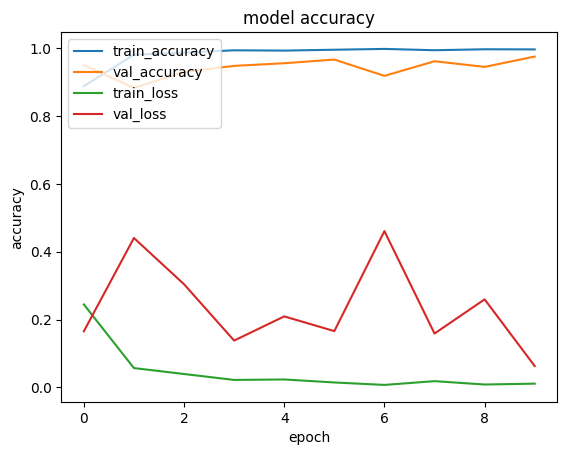

K-Fold Results:
Acuracy: 0.9464426413178444 	 +/- 0.019095115020023853
Precision: 0.8769615665078163 	 +/- 0.05131914313071593
Recall: 0.9182041436433792 	 +/- 0.026297088213055434
AUC: 0.9829004576461416 	 +/- 0.01312768899970908
F1: 0.8963592317015268 	 +/- 0.03236457038933935


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9685039520263672, Test Precision: 0.9521912336349487, Test Recall: 0.9157088398933411, Test AUC: 0.9863197092148286, Test F1 Score: 0.9335937636765264


In [10]:
# SMOTE
# BARD
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='models/simclr-bard_epoch_3.h5', learning_rate=0.0003, num_classes=1, name="resnet10_bard_SimCLR_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8976660966873169, Val Precision: 0.7955800890922546, Val Recall: 0.651583731174469, Val AUC: 0.9356533723834956, Val F1 Score: 0.7164179143219666
Test Accuracy: 0.8374247550964355, Test Precision: 0.6904231905937195, Test Recall: 0.5938697457313538, Test AUC: 0.8817011775114277,Test F1 Score: 0.6385170128213487

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7568851113319397, Val Precision: 0.5087282061576843, Val Recall: 0.7756654024124146, Val AUC: 0.8163474033787359, Val F1 Score: 0.6144578517284168
Test Accuracy: 0.7012505531311035, Test Precision: 0.4295532703399658, Test Recall: 0.7183908224105835, Test AUC: 0.7602169186227493,Test F1 Score: 0.537634418082659

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7372400760650635, Val Precision: 0.5255255103111267, Val Recall: 0.5932203531265259, Val AUC: 0.76601061821

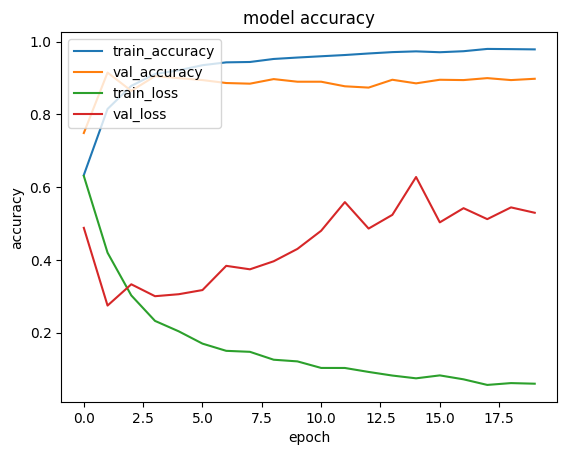

K-Fold Results:
Acuracy: 0.7642235457897186 	 +/- 0.055467524364266836
Precision: 0.5432984456419945 	 +/- 0.1118012773414976
Recall: 0.7340260222554207 	 +/- 0.10542568105441988
AUC: 0.8260891643258189 	 +/- 0.04781558568118828
F1: 0.6122348295579882 	 +/- 0.05977433641937083


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.8374247550964355, Test Precision: 0.6904231905937195, Test Recall: 0.5938697457313538, Test AUC: 0.8817011775114277, Test F1 Score: 0.6385170128213487


In [17]:
# Deep SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=20, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_ptbxl_deep_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.830341100692749, Val Precision: 0.7758620977401733, Val Recall: 0.20361991226673126, Val AUC: 0.7046206543604607, Val F1 Score: 0.3225806511174667
Test Accuracy: 0.7823066115379333, Test Precision: 0.7599999904632568, Test Recall: 0.14559386670589447, Test AUC: 0.6936843632754993,Test F1 Score: 0.24437298559837842

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.708452045917511, Val Precision: 0.34507042169570923, Val Recall: 0.1863117814064026, Val AUC: 0.5495211050681041, Val F1 Score: 0.2419753036570247
Test Accuracy: 0.6896711587905884, Test Precision: 0.29891303181648254, Test Recall: 0.2107279747724533, Test AUC: 0.5644904589041256,Test F1 Score: 0.24719101097995808

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.8015123009681702, Val Precision: 0.7053139805793762, Val Recall: 0.494915246963501, Val AUC: 0.788841

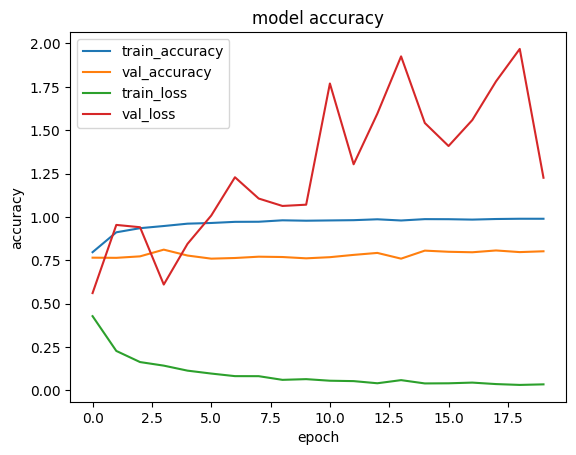

K-Fold Results:
Acuracy: 0.7607792690396309 	 +/- 0.05082618863700348
Precision: 0.6276213936507702 	 +/- 0.22819733190403374
Recall: 0.34055260941386223 	 +/- 0.11568502508174204
AUC: 0.6836024695129119 	 +/- 0.06988205787635579
F1: 0.408730426456454 	 +/- 0.09769986072569986


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.8031495809555054, Test Precision: 0.6328766942024231, Test Recall: 0.44252872467041016, Test AUC: 0.7539057288704457, Test F1 Score: 0.5208568070125027


In [11]:
# Deep SMOTE
# BARD
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=20, weights_path='models/simclr-bard_epoch_3.h5', learning_rate=0.0003, num_classes=1, name="resnet10_bard_deep_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9174147248268127, Val Precision: 0.759036123752594, Val Recall: 0.8552036285400391, Val AUC: 0.9531347382608828, Val F1 Score: 0.8042553112748628
Test Accuracy: 0.9217230081558228, Test Precision: 0.8238531947135925, Test Recall: 0.8601532578468323, Test AUC: 0.9631065143461663,Test F1 Score: 0.8416119882949085

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9154796004295349, Val Precision: 0.8883928656578064, Val Recall: 0.7566539645195007, Val AUC: 0.9580642056119748, Val F1 Score: 0.8172484473020959
Test Accuracy: 0.925891637802124, Test Precision: 0.8441064357757568, Test Recall: 0.8505747318267822, Test AUC: 0.9561785997654807,Test F1 Score: 0.8473282396345309

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9111531376838684, Val Precision: 0.9718309640884399, Val Recall: 0.701694905757904, Val AUC: 0.962134304818

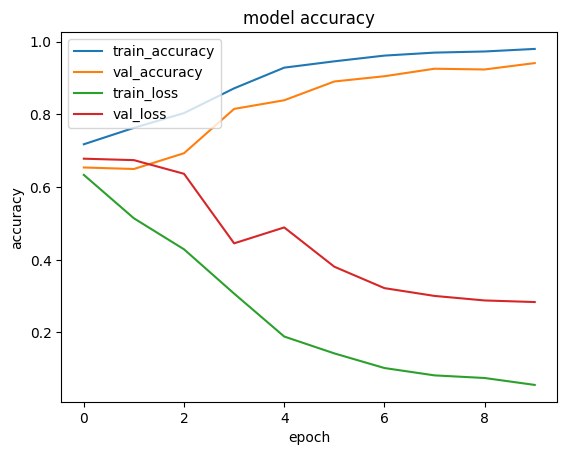

K-Fold Results:
Acuracy: 0.9251729175448418 	 +/- 0.01591986716521753
Precision: 0.8973045200109482 	 +/- 0.07267256523129173
Recall: 0.7837074846029282 	 +/- 0.08783391994773365
AUC: 0.9696678602340194 	 +/- 0.011588940305641908
F1: 0.8323172582257261 	 +/- 0.05904008472816184


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9328392744064331, Test Precision: 0.9274376630783081, Test Recall: 0.7835249304771423, Test AUC: 0.969132161673185, Test F1 Score: 0.8494288925104593


In [12]:
# all data no smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_all_pretrain_epoch_5.h5', learning_rate=0.0002, num_classes=1, name="resnet10_all_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9569120407104492, Val Precision: 0.9178743958473206, Val Recall: 0.8597285151481628, Val AUC: 0.9565752737480556, Val F1 Score: 0.887850471613386
Test Accuracy: 0.9481241106987, Test Precision: 0.9051383137702942, Test Recall: 0.8773946166038513, Test AUC: 0.9782894136316082,Test F1 Score: 0.8910505609758945

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9221272468566895, Val Precision: 0.8986784219741821, Val Recall: 0.7756654024124146, Val AUC: 0.9666987534292728, Val F1 Score: 0.832653066433752
Test Accuracy: 0.9499768614768982, Test Precision: 0.9156626462936401, Test Recall: 0.8735632300376892, Test AUC: 0.9869773929976572,Test F1 Score: 0.8941176511053395

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9158790111541748, Val Precision: 0.8786764740943909, Val Recall: 0.810169517993927, Val AUC: 0.975044983006419

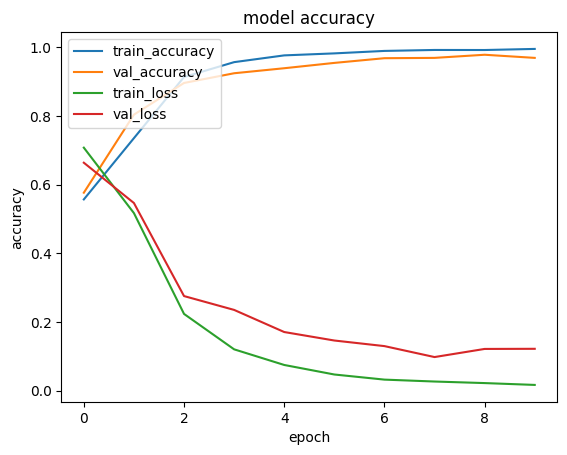

K-Fold Results:
Acuracy: 0.9438274577260017 	 +/- 0.018426901653831762
Precision: 0.897353008389473 	 +/- 0.044997078482183005
Recall: 0.8752337992191315 	 +/- 0.052055676476575705
AUC: 0.9762289568284366 	 +/- 0.015364577817153828
F1: 0.8848880924547782 	 +/- 0.03709963829846308


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9397869110107422, Test Precision: 0.8643122911453247, Test Recall: 0.8908045887947083, Test AUC: 0.9772116080017414, Test F1 Score: 0.8773584983471066


In [13]:
# all data smote
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_all_pretrain_epoch_5.h5', learning_rate=0.0002, num_classes=1, name="resnet10_all_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7271094918251038, Val Precision: 0.3893333375453949, Val Recall: 0.6606335043907166, Val AUC: 0.7545109524557517, Val F1 Score: 0.4899328948035457
Test Accuracy: 0.6980083584785461, Test Precision: 0.40091463923454285, Test Recall: 0.5038314461708069, Test AUC: 0.6476119759301778,Test F1 Score: 0.4465195389844406

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8157644867897034, Val Precision: 0.6455696225166321, Val Recall: 0.5817490220069885, Val AUC: 0.8653607354285989, Val F1 Score: 0.6119999858427044
Test Accuracy: 0.7721167206764221, Test Precision: 0.5352112650871277, Test Recall: 0.4367816150188446, Test AUC: 0.7401704360607316,Test F1 Score: 0.4810126607420161

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.6162570714950562, Val Precision: 0.3977900445461273, Val Recall: 0.7322033643722534, Val AUC: 0.68290423

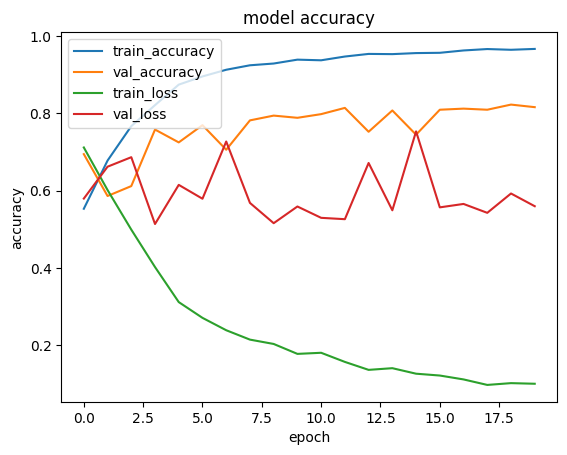

K-Fold Results:
Acuracy: 0.7177459672093391 	 +/- 0.06686644295749183
Precision: 0.47574422135949135 	 +/- 0.09570709825429619
Recall: 0.6383410021662712 	 +/- 0.09384299715313828
AUC: 0.7621115346229553 	 +/- 0.05319092403702395
F1: 0.5327428892721641 	 +/- 0.05395819337495511


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.7721167206764221, Test Precision: 0.5352112650871277, Test Recall: 0.4367816150188446, Test AUC: 0.7401704360607316, Test F1 Score: 0.4810126607420161


In [14]:
# all data deep smote
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=20, weights_path='models/resnet10_simclr_all_pretrain_epoch_5.h5', learning_rate=0.0002, num_classes=1, name="resnet10_all_deep_smote_brugada.h5")

# MoCo v2


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8761062026023865, Val Recall: 0.8959276080131531, Val AUC: 0.9894149062846778, Val F1 Score: 0.8859060473461146
Test Accuracy: 0.9550718069076538, Test Precision: 0.8708551526069641, Test Recall: 0.9559386968612671, Test AUC: 0.9836632284550049,Test F1 Score: 0.91141552724228

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9316239356994629, Val Precision: 0.9321267008781433, Val Recall: 0.7832699418067932, Val AUC: 0.9627039514848148, Val F1 Score: 0.8512396591969764
Test Accuracy: 0.9620194435119629, Test Precision: 0.9166666865348816, Test Recall: 0.9272030591964722, Test AUC: 0.9834420501009932,Test F1 Score: 0.9219047690177449

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9187145829200745, Val Precision: 0.8884758353233337, Val Recall: 0.810169517993927, Val AUC: 0.946171446342

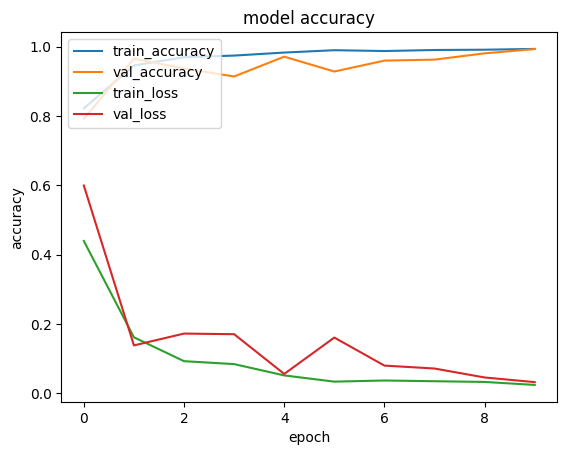

K-Fold Results:
Acuracy: 0.9473043233156204 	 +/- 0.031379172725056886
Precision: 0.897677406668663 	 +/- 0.054913521918609334
Recall: 0.9053474068641663 	 +/- 0.07087380807589685
AUC: 0.9743871175612816 	 +/- 0.017750832684060493
F1: 0.8994550431619386 	 +/- 0.04840733849475024


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.946734607219696, Test Precision: 0.8397328853607178, Test Recall: 0.9636015295982361, Test AUC: 0.9841845774323184, Test F1 Score: 0.8974130212071015


In [20]:
# NO SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="resnet10_ptbxl_moco_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9254937171936035, Val Precision: 0.859375, Val Recall: 0.7466063499450684, Val AUC: 0.9100495052013399, Val F1 Score: 0.7990314856470645
Test Accuracy: 0.9221861958503723, Test Precision: 0.8568548560142517, Test Recall: 0.8141762614250183, Test AUC: 0.9696423932200058,Test F1 Score: 0.8349705471943848

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9268755912780762, Val Precision: 0.8690476417541504, Val Recall: 0.8326995968818665, Val AUC: 0.9609808923328682, Val F1 Score: 0.8504854358275223
Test Accuracy: 0.9254284501075745, Test Precision: 0.8752598762512207, Test Recall: 0.8065134286880493, Test AUC: 0.969128650905661,Test F1 Score: 0.839481565934287

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9054820537567139, Val Precision: 0.8823529481887817, Val Recall: 0.7627118825912476, Val AUC: 0.9631183775018327, Val

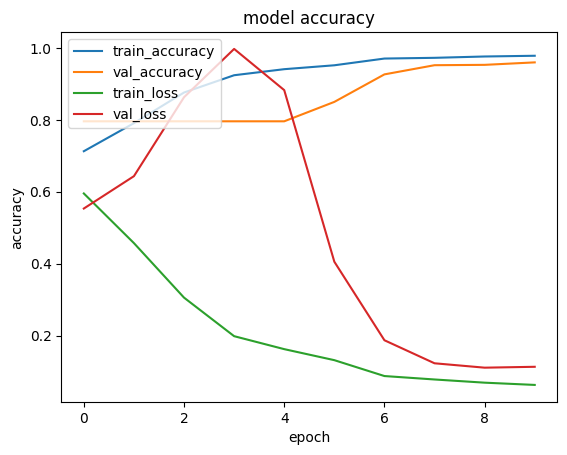

K-Fold Results:
Acuracy: 0.9243728145956993 	 +/- 0.019680447179395304
Precision: 0.8942761942744255 	 +/- 0.037179548312195054
Recall: 0.7980545982718468 	 +/- 0.05327234325177028
AUC: 0.9506102416719394 	 +/- 0.026883385049312272
F1: 0.8417547836866226 	 +/- 0.02980953126815212


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9194071292877197, Test Precision: 0.8295454382896423, Test Recall: 0.8390804529190063, Test AUC: 0.9620813702291595, Test F1 Score: 0.8342857026781354


In [15]:
# NO SMOTE
# BARD

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_5.h5', learning_rate=0.0001, num_classes=1, name="resnet10_bard_moco_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9802513718605042, Val Precision: 0.9383260011672974, Val Recall: 0.9638009071350098, Val AUC: 0.9971117743333012, Val F1 Score: 0.950892863316433
Test Accuracy: 0.9564613103866577, Test Precision: 0.8702422380447388, Test Recall: 0.9636015295982361, Test AUC: 0.9890230002083056,Test F1 Score: 0.9145454661917093

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9420702457427979, Val Precision: 0.9316239356994629, Val Recall: 0.8288973569869995, Val AUC: 0.9437647398565723, Val F1 Score: 0.8772635937038209
Test Accuracy: 0.9675775766372681, Test Precision: 0.9139193892478943, Test Recall: 0.9559386968612671, Test AUC: 0.993957383963282,Test F1 Score: 0.934456915724324

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9177693724632263, Val Precision: 0.8270440101623535, Val Recall: 0.8915254473686218, Val AUC: 0.972979096785

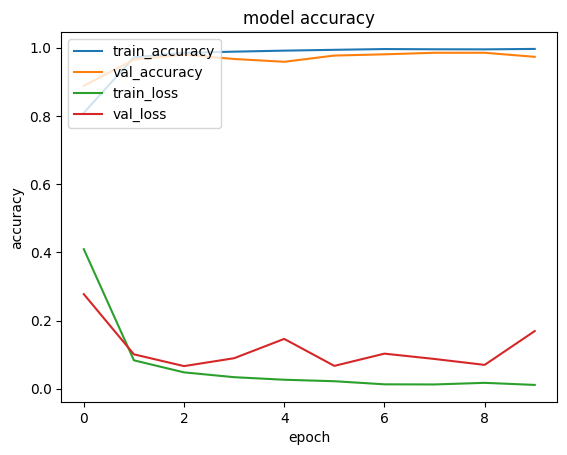

K-Fold Results:
Acuracy: 0.9534400701522827 	 +/- 0.020120794818621678
Precision: 0.895521953701973 	 +/- 0.052302830734009556
Recall: 0.9277016520500183 	 +/- 0.04636124023895939
AUC: 0.983462003345432 	 +/- 0.01736594515023358
F1: 0.9098423875644978 	 +/- 0.034288208131423095


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9624826312065125, Test Precision: 0.8916518688201904, Test Recall: 0.961685836315155, Test AUC: 0.9883846256468589, Test F1 Score: 0.9253456299867325


In [22]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="moco_bard_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9434470534324646, Val Precision: 0.9247311949729919, Val Recall: 0.7782805562019348, Val AUC: 0.9295171596074041, Val F1 Score: 0.8452088580884198
Test Accuracy: 0.9170912504196167, Test Precision: 0.8158379197120667, Test Recall: 0.8486589789390564, Test AUC: 0.9646038566951508,Test F1 Score: 0.8319248614805933

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9316239356994629, Val Precision: 0.8447653651237488, Val Recall: 0.8897338509559631, Val AUC: 0.9680560234875103, Val F1 Score: 0.8666666833837663
Test Accuracy: 0.9272811412811279, Test Precision: 0.8288288116455078, Test Recall: 0.8812260627746582, Test AUC: 0.9683644738412712,Test F1 Score: 0.854224693401402

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.8950850367546082, Val Precision: 0.8357664346694946, Val Recall: 0.7762711644172668, Val AUC: 0.9485061199

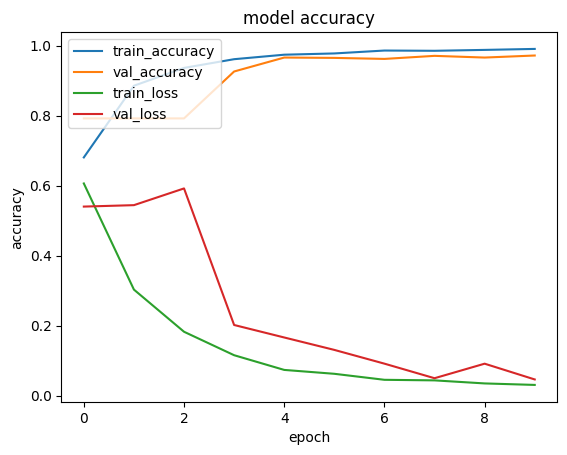

K-Fold Results:
Acuracy: 0.9368750005960464 	 +/- 0.02410106578778208
Precision: 0.8939898535609245 	 +/- 0.04713353803703787
Recall: 0.8599013686180115 	 +/- 0.0710143761806869
AUC: 0.9680640465803625 	 +/- 0.022669532939531913
F1: 0.8740265202780346 	 +/- 0.03753987089567279


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9170912504196167, Test Precision: 0.8057041168212891, Test Recall: 0.8659003973007202, Test AUC: 0.9638589888521429, Test F1 Score: 0.8347183905863255


In [17]:
# SMOTE
# BARD

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_5.h5', learning_rate=0.0001, num_classes=1, name="resnet10_bard_moco_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7280071973800659, Val Precision: 0.21917808055877686, Val Recall: 0.14479638636112213, Val AUC: 0.541633519632334, Val F1 Score: 0.17438692501175962
Test Accuracy: 0.7257989645004272, Test Precision: 0.3758865296840668, Test Recall: 0.20306512713432312, Test AUC: 0.6010820185508956,Test F1 Score: 0.2636815873637552

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7350427508354187, Val Precision: 0.4375, Val Recall: 0.21292775869369507, Val AUC: 0.6362107137700341, Val F1 Score: 0.2864450146333971
Test Accuracy: 0.7142195701599121, Test Precision: 0.3442623019218445, Test Recall: 0.20114941895008087, Test AUC: 0.6448846946919536,Test F1 Score: 0.2539298638001119

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7306238412857056, Val Precision: 0.7083333134651184, Val Recall: 0.0576271191239357, Val AUC: 0.8186018615189817

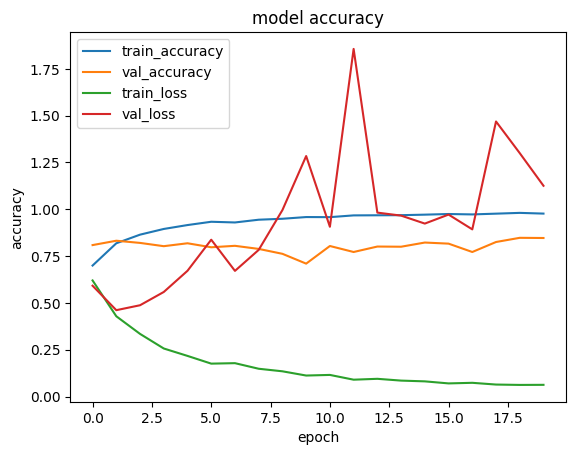

K-Fold Results:
Acuracy: 0.750789001584053 	 +/- 0.05282404198254123
Precision: 0.5406130328774452 	 +/- 0.17115483125518605
Recall: 0.23621338326483965 	 +/- 0.1320295671326956
AUC: 0.6972532352601537 	 +/- 0.08564021541352505
F1: 0.30895221949220036 	 +/- 0.1448933317725948


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.7628531455993652, Test Precision: 0.5146198868751526, Test Recall: 0.3371647596359253, Test AUC: 0.7431428858977149, Test F1 Score: 0.40740741494422156


In [13]:
# Deep SMOTE
# PTB-XL

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=20, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="moco_ptbxl_deep_smote_brugada.h5")

In [18]:
# Deep SMOTE
# BARD

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=20, weights_path='model-weights/test_moco_BARD_5.h5', learning_rate=0.0005, num_classes=1, name="moco_bard_deep_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7971274852752686, Val Precision: 0.48447203636169434, Val Recall: 0.3529411852359772, Val AUC: 0.6547911610160475, Val F1 Score: 0.4083769644834547
Test Accuracy: 0.7698008418083191, Test Precision: 0.5698323845863342, Test Recall: 0.19540229439735413, Test AUC: 0.7217564603973721,Test F1 Score: 0.2910128315615938

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7312440872192383, Val Precision: 0.261904776096344, Val Recall: 0.04182509332895279, Val AUC: 0.5862973480290705, Val F1 Score: 0.07213114550936378
Test Accuracy: 0.7406206727027893, Test Precision: 0.02500000037252903, Test Recall: 0.0019157087663188577, Test AUC: 0.5783778849732129,Test F1 Score: 0.003558718785714935

Training on fold 3
34/34 [==============================] - 0s 4ms/step


ZeroDivisionError: float division by zero


Training on fold 1


2024-09-12 11:02:28.864797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-12 11:02:29.005399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-12 11:02:29.005608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-12 11:02:29.006207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9245960712432861, Val Precision: 0.910179615020752, Val Recall: 0.6877828240394592, Val AUC: 0.960041144548094, Val F1 Score: 0.7835051571929128
Test Accuracy: 0.9333024621009827, Test Precision: 0.9478672742843628, Test Recall: 0.7662835121154785, Test AUC: 0.9778458866677433,Test F1 Score: 0.847457609588055

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.934472918510437, Val Precision: 0.8702290058135986, Val Recall: 0.8669201731681824, Val AUC: 0.9719978822736681, Val F1 Score: 0.8685714382435458
Test Accuracy: 0.9522927403450012, Test Precision: 0.9021113514900208, Test Recall: 0.9003831148147583, Test AUC: 0.9729635792977059,Test F1 Score: 0.9012464046333395

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9092627763748169, Val Precision: 0.8644688725471497, Val Recall: 0.800000011920929, Val AUC: 0.9636204100673078, Val F1 Score: 0.

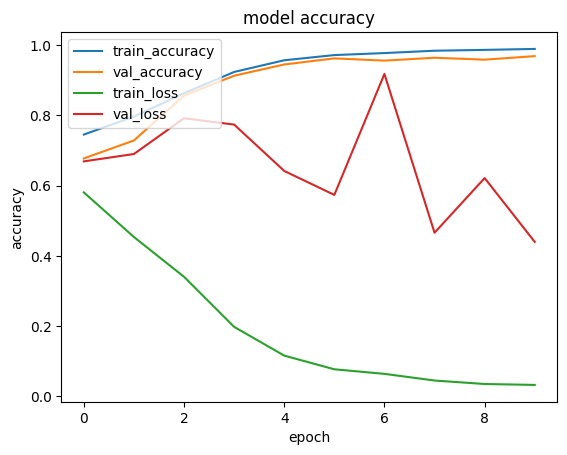

K-Fold Results:
Acuracy: 0.9448391422629356 	 +/- 0.022202237225185707
Precision: 0.8987239301204681 	 +/- 0.026530815940377938
Recall: 0.8764832094311714 	 +/- 0.10208989998943799
AUC: 0.976680844620489 	 +/- 0.013456287501490694
F1: 0.8841159867799018 	 +/- 0.05550594823696291


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9481241106987, Test Precision: 0.8740875720977783, Test Recall: 0.9176245331764221, Test AUC: 0.9600732112054338, Test F1 Score: 0.8953270985226575


In [9]:
# all data no smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_all_pretrain_unlabelled_HB_7.h5', learning_rate=0.0005, num_classes=1, name="moco_all_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.9447236061096191, Val Recall: 0.8506787419319153, Val AUC: 0.9801371147132296, Val F1 Score: 0.8952380947873434
Test Accuracy: 0.9509031772613525, Test Precision: 0.8727598786354065, Test Recall: 0.9329501986503601, Test AUC: 0.9701069847890145,Test F1 Score: 0.9018518669075435

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9515669345855713, Val Precision: 0.9108527302742004, Val Recall: 0.8935361504554749, Val AUC: 0.9774799056649179, Val F1 Score: 0.9021113474296559
Test Accuracy: 0.9638721346855164, Test Precision: 0.93359375, Test Recall: 0.9157088398933411, Test AUC: 0.9717839614096433,Test F1 Score: 0.9245648109901586

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9310019016265869, Val Precision: 0.8700000047683716, Val Recall: 0.8847457766532898, Val AUC: 0.9568962836261857,

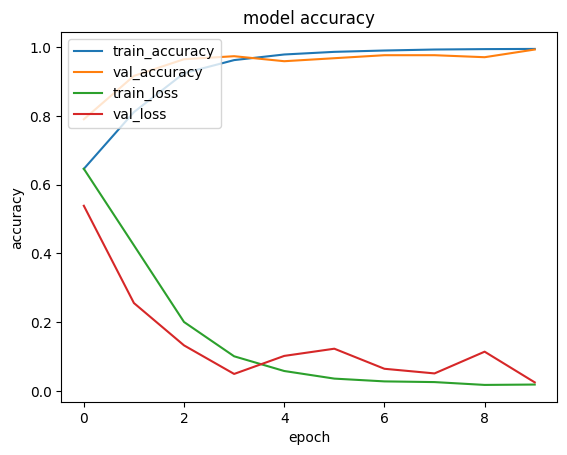

K-Fold Results:
Acuracy: 0.9596551358699799 	 +/- 0.019110088717067326
Precision: 0.9232390746474266 	 +/- 0.043452232325965116
Recall: 0.9140986055135727 	 +/- 0.05050797487328263
AUC: 0.9826428148802124 	 +/- 0.013389377207349928
F1: 0.9180115426549522 	 +/- 0.04047656149126268


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9495136737823486, Test Precision: 0.8694096803665161, Test Recall: 0.931034505367279, Test AUC: 0.9707945100957971, Test F1 Score: 0.8991674589364304


In [10]:
# all data smote
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_all_pretrain_unlabelled_HB_7.h5', learning_rate=0.0005, num_classes=1, name="moco_all_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7971274852752686, Val Precision: 0.47787609696388245, Val Recall: 0.24434389173984528, Val AUC: 0.6382066652141087, Val F1 Score: 0.32335329159520954
Test Accuracy: 0.7702640295028687, Test Precision: 0.5380116701126099, Test Recall: 0.3524904251098633, Test AUC: 0.7193884477024367,Test F1 Score: 0.4259259205104573

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.6533713340759277, Val Precision: 0.21022726595401764, Val Recall: 0.14068441092967987, Val AUC: 0.4489026327188719, Val F1 Score: 0.1685649182993724
Test Accuracy: 0.7628531455993652, Test Precision: 0.5127550959587097, Test Recall: 0.3850574791431427, Test AUC: 0.7442698422729177,Test F1 Score: 0.43982494819759543

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.6398865580558777, Val Precision: 0.4285714328289032, Val Recall: 0.8745762705802917, Val AUC: 0.820

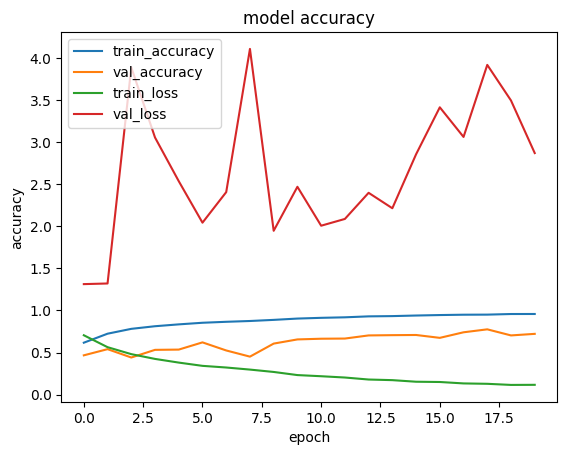

K-Fold Results:
Acuracy: 0.6296472288668156 	 +/- 0.10217552735081085
Precision: 0.3693145886063576 	 +/- 0.11935647079065076
Recall: 0.5774971693754196 	 +/- 0.24910210612844166
AUC: 0.6783406475912075 	 +/- 0.10193836163461074
F1: 0.41910653714061374 	 +/- 0.13071784911217518


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.6262158155441284, Test Precision: 0.3654390871524811, Test Recall: 0.7413793206214905, Test AUC: 0.7424553605909324, Test F1 Score: 0.4895635639210867


In [11]:
# all data deep smote
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=20, weights_path='model-weights/test_moco_all_pretrain_unlabelled_HB_7.h5', learning_rate=0.0005, num_classes=1, name="moco_all_deep_smote_brugada.h5")

# Auto-Encoder

In [8]:
def encoder(inputs, latent_dim):
    # 100 x 12
    X = keras.layers.Conv1D(24, 5, activation='linear', padding='same', name='conv1')(inputs)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    # 100 x 24
    X = keras.layers.MaxPooling1D(2, padding='same')(X)
    X = keras.layers.Dropout(0.3)(X)
    # 50 x 24
    X = keras.layers.Conv1D(48, 5, activation='linear', padding='same', name='conv2')(X)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    # 50 x 48
    X = keras.layers.MaxPooling1D(2, padding='same')(X)
    X = keras.layers.Dropout(0.3)(X)
    # 25 x 48
    X = keras.layers.Conv1D(64, 5, activation='linear', padding='same', name='conv3')(X)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    # 25 x 64
    X = keras.layers.MaxPooling1D(2, padding='same')(X)
    X = keras.layers.Dropout(0.3)(X)
    # 13 x 64
    X = keras.layers.Flatten()(X)
    # 832
    X = keras.layers.Dense(latent_dim, activation='linear', name='dense-encode')(X)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    return X


In [9]:
def classification_head(inputs, num_classes):
    X = keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense1')(inputs)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense2')(X)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid', name='dense3')(X)
    return X

In [10]:
def k_fold_autoencoder_classification(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5", freeze_layers=3):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        enc = encoder(X_input, 256)
        classiifier = classification_head(enc, 1)
        model = keras.Model(inputs=X_input, outputs=classiifier)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        
        layers_to_freeze_substrings = [f"conv{i}" for i in range(1, freeze_layers+1)]
        
        if weights_path:
            model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        
        y_pred = model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        y_pred = model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        print(f"Val Accuracy: {val_accuracy}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
            
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")

    # load best model
    enc = encoder(X_input, 256)
    classiifier = classification_head(enc, 1)
    model = keras.Model(inputs=X_input, outputs=classiifier)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    model.load_weights(f'model-weights/fine-tuned/{name}')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    
    


Training on fold 1
68/68 [==============================] - 0s 923us/step
Val Accuracy: 0.9506283402442932, Val AUC: 0.9929415818355941, Val F1 Score: 0.8655256696550961
Test Accuracy: 0.9397869110107422, Test AUC: 0.9747388574090068, Test F1 Score: 0.8722986257133176

Training on fold 2
68/68 [==============================] - 0s 890us/step
Val Accuracy: 0.9221272468566895, Val AUC: 0.978971940126101, Val F1 Score: 0.8373015966190367
Test Accuracy: 0.9546086192131042, Test AUC: 0.9869493068574652, Test F1 Score: 0.9048543465617285

Training on fold 3
68/68 [==============================] - 0s 946us/step
Val Accuracy: 0.8950850367546082, Val AUC: 0.9536974920585558, Val F1 Score: 0.7970749358917882
Test Accuracy: 0.9430291652679443, Test AUC: 0.9737066917569519, Test F1 Score: 0.8838526829410492

Training on fold 4
68/68 [==============================] - 0s 950us/step
Val Accuracy: 0.9194214940071106, Val AUC: 0.9797741152059607, Val F1 Score: 0.8769715988311803
Test Accuracy: 0.951

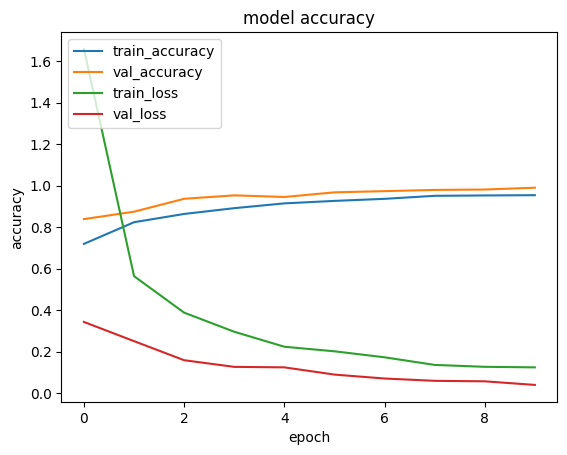

K-Fold Results:
Acuracy: 0.9318112730979919 	 +/- 0.03250140474252044
Precision: 0.9206348285079002 	 +/- 0.04265460974777101
Recall: 0.8049180507659912 	 +/- 0.10415958590337894
AUC: 0.972112349109524 	 +/- 0.021243035975019486
F1: 0.8560162186323206 	 +/- 0.07121273815125749


68/68 [==============================] - 0s 938us/step

Test Performance:
Test Accuracy: 0.9407132863998413, Test AUC: 0.972734209152805, Test F1 Score: 0.8773946166038513


In [49]:
# no smote
k_fold_autoencoder_classification(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_no_smote.h5", freeze_layers=3)


Training on fold 1
68/68 [==============================] - 0s 962us/step
Val Accuracy: 0.9470376968383789, Val AUC: 0.9676012019072423, Val F1 Score: 0.8643678306629232
Test Accuracy: 0.9370078444480896, Test AUC: 0.9790998158017306, Test F1 Score: 0.8719397386029268

Training on fold 2
68/68 [==============================] - 0s 950us/step
Val Accuracy: 0.918328583240509, Val AUC: 0.9725032487847138, Val F1 Score: 0.8300395316164061
Test Accuracy: 0.9462714195251465, Test AUC: 0.9845760280112438, Test F1 Score: 0.8893129612064591

Training on fold 3
68/68 [==============================] - 0s 936us/step
Val Accuracy: 0.920604944229126, Val AUC: 0.9623742141857521, Val F1 Score: 0.8531468401417661
Test Accuracy: 0.9365447163581848, Test AUC: 0.9828036755395465, Test F1 Score: 0.8720821612097259

Training on fold 4
68/68 [==============================] - 0s 926us/step
Val Accuracy: 0.9535123705863953, Val AUC: 0.9896111857772748, Val F1 Score: 0.9319213270146001
Test Accuracy: 0.9536

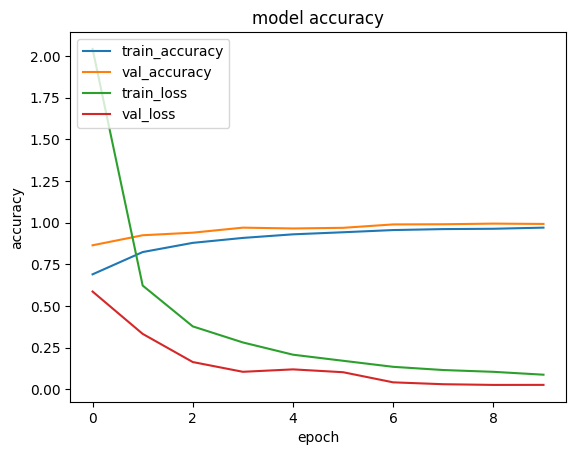

K-Fold Results:
Acuracy: 0.9448612034320831 	 +/- 0.02502929296894625
Precision: 0.9034843295812607 	 +/- 0.04243258133362529
Recall: 0.8733948469161987 	 +/- 0.07993689649587218
AUC: 0.9756677990377185 	 +/- 0.014302451540400793
F1: 0.8869461045989269 	 +/- 0.05540365802878109


68/68 [==============================] - 0s 958us/step

Test Performance:
Test Accuracy: 0.9434923529624939, Test AUC: 0.9873799610070754, Test F1 Score: 0.8876611413268977


In [50]:
# smote
k_fold_autoencoder_classification(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_smote.h5", freeze_layers=3)


Training on fold 1
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9578096866607666, Val AUC: 0.9809985153506661, Val F1 Score: 0.8878281667367081
Test Accuracy: 0.958314061164856, Test AUC: 0.9858118181796904, Test F1 Score: 0.9174311835042817

Training on fold 2
68/68 [==============================] - 0s 992us/step
Val Accuracy: 0.9534662961959839, Val AUC: 0.9845405977763872, Val F1 Score: 0.9037328093520344
Test Accuracy: 0.94210284948349, Test AUC: 0.9814631474733005, Test F1 Score: 0.891398805421966

Training on fold 3
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9310019016265869, Val AUC: 0.9757336117466735, Val F1 Score: 0.8726003468311677
Test Accuracy: 0.9587771892547607, Test AUC: 0.9870230329754691, Test F1 Score: 0.9164319111207865

Training on fold 4
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9163222908973694, Val AUC: 0.9840890335054584, Val F1 Score: 0.8687196288228157
Test Accuracy: 0.962019443511

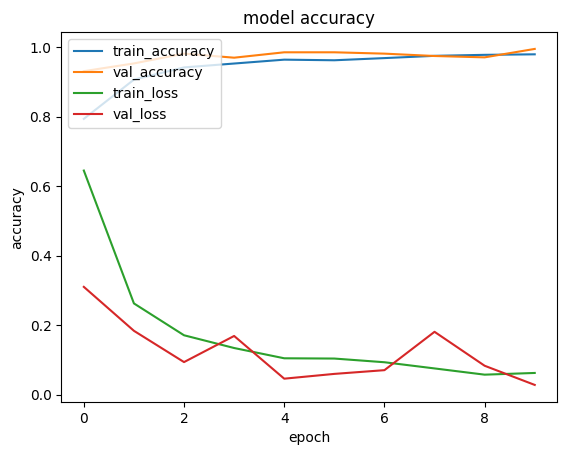

K-Fold Results:
Acuracy: 0.9568328335881233 	 +/- 0.02304416583629407
Precision: 0.9437394663691521 	 +/- 0.0374633969427694
Recall: 0.8876417949795723 	 +/- 0.0689451409402602
AUC: 0.9863841408683904 	 +/- 0.0068125377019245675
F1: 0.9130024850702823 	 +/- 0.039574222747117103


68/68 [==============================] - 0s 1ms/step

Test Performance:
Test Accuracy: 0.9458082318305969, Test AUC: 0.9856971331072399, Test F1 Score: 0.893150679330974


In [12]:
# bard no smote
k_fold_autoencoder_classification(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_bard_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_bard_no_smote.h5", freeze_layers=3)


Training on fold 1
68/68 [==============================] - 0s 994us/step
Val Accuracy: 0.9622980356216431, Val AUC: 0.9923994061402664, Val F1 Score: 0.9027777801003353
Test Accuracy: 0.9573876857757568, Test AUC: 0.9868627079252066, Test F1 Score: 0.91238097297902

Training on fold 2
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9525166153907776, Val AUC: 0.9697646435962843, Val F1 Score: 0.8987854030771277
Test Accuracy: 0.9610931277275085, Test AUC: 0.987196815967907, Test F1 Score: 0.923357660703393

Training on fold 3
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9480150938034058, Val AUC: 0.9846302507941445, Val F1 Score: 0.9090909136016626
Test Accuracy: 0.950439989566803, Test AUC: 0.9934957180338765, Test F1 Score: 0.9047194778269402

Training on fold 4
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9493801593780518, Val AUC: 0.987531536629648, Val F1 Score: 0.9247311851466872
Test Accuracy: 0.96109312772750

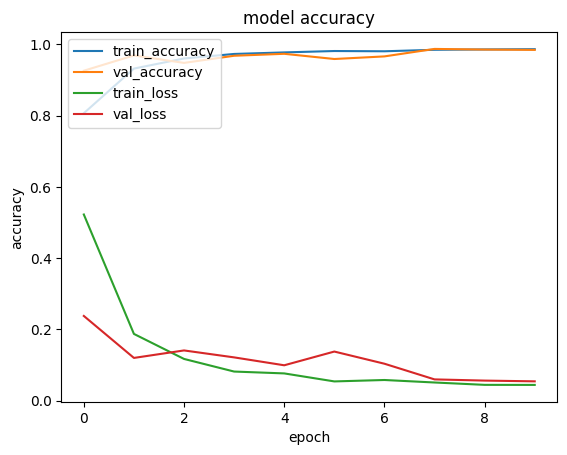

K-Fold Results:
Acuracy: 0.964270792901516 	 +/- 0.012975068251404794
Precision: 0.9296444579958916 	 +/- 0.045387541897033284
Recall: 0.929803878068924 	 +/- 0.0502886066843045
AUC: 0.9895522038406954 	 +/- 0.008510051214709402
F1: 0.9278776074195433 	 +/- 0.024708472261519336


68/68 [==============================] - 0s 1ms/step

Test Performance:
Test Accuracy: 0.9555349946022034, Test AUC: 0.9908140767734642, Test F1 Score: 0.9132007233397792


In [13]:
# bard smote
k_fold_autoencoder_classification(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_bard_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_bard_smote.h5", freeze_layers=3)

In [5]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_deep_resampled_per_fold_v2.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)

print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)

print(X_train_resampled_deep.shape, Y_train_resampled_deep.shape)
print(folds_train_resampled_deep.shape)


print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

Y_train_resampled = np.where(Y_train_resampled == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


# Norm + RBBB dataset pretrained models


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9111310839653015, Val Precision: 0.7147887349128723, Val Recall: 0.918552041053772, Val AUC: 0.9785967276909903, Val F1 Score: 0.8039603994921275
Test Accuracy: 0.9374710321426392, Test Precision: 0.8166939616203308, Test Recall: 0.9559386968612671, Test AUC: 0.9874536871250792,Test F1 Score: 0.8808473178809025

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8945869207382202, Val Precision: 0.7360248565673828, Val Recall: 0.9011406898498535, Val AUC: 0.9635510420176157, Val F1 Score: 0.8102564196336155
Test Accuracy: 0.9407132863998413, Test Precision: 0.8261589407920837, Test Recall: 0.9559386968612671, Test AUC: 0.9880551986275239,Test F1 Score: 0.8863232682368786

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.760869562625885, Val Precision: 0.5415019989013672, Val Recall: 0.9288135766983032, Val AUC: 0.92625008330

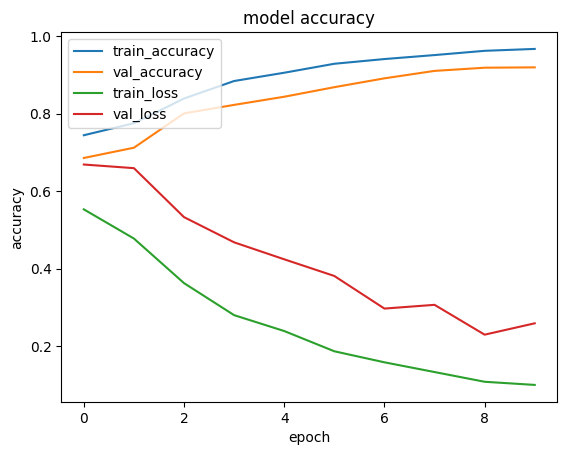

K-Fold Results:
Acuracy: 0.8725826293230057 	 +/- 0.045766738198340574
Precision: 0.7044006809592247 	 +/- 0.11412324120242388
Recall: 0.8993037268519402 	 +/- 0.06382334746070104
AUC: 0.9433270783620795 	 +/- 0.03666969580637607
F1: 0.7813483929445646 	 +/- 0.054563561071029144


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9346919655799866, Test Precision: 0.9096774458885193, Test Recall: 0.8103448152542114, Test AUC: 0.9729015557381154, Test F1 Score: 0.8571428620228593


In [27]:
# simclr china pretrain no smote

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.0001, num_classes=1, name="resnet10_simclr_china_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8601694703102112, Val Recall: 0.918552041053772, Val AUC: 0.9921105835735965, Val F1 Score: 0.8884026167758025
Test Accuracy: 0.965261697769165, Test Precision: 0.8969804644584656, Test Recall: 0.967432975769043, Test AUC: 0.9962399679818001,Test F1 Score: 0.9308755893026179

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9278252720832825, Val Precision: 0.8213058710098267, Val Recall: 0.9087452292442322, Val AUC: 0.9759854646965396, Val F1 Score: 0.8628158924564202
Test Accuracy: 0.9564613103866577, Test Precision: 0.8474025726318359, Test Recall: 1.0, Test AUC: 0.9983417474728324,Test F1 Score: 0.9173989310024768

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9536861777305603, Val Precision: 0.9241379499435425, Val Recall: 0.9084745645523071, Val AUC: 0.9864229069018371, Val F1 Sc

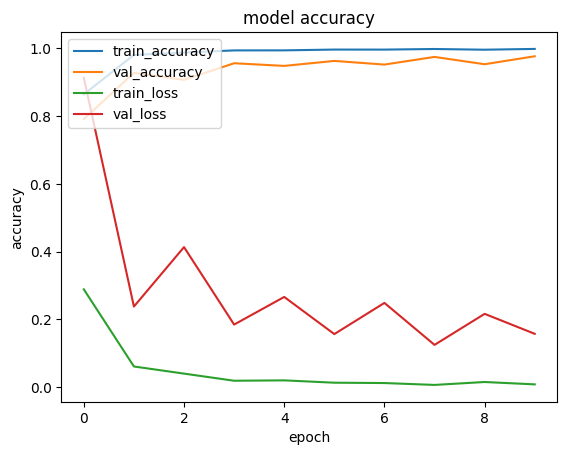

K-Fold Results:
Acuracy: 0.9515037536621094 	 +/- 0.01468553475837147
Precision: 0.8855541050434113 	 +/- 0.03884359817774906
Recall: 0.9312944188714027 	 +/- 0.04580824039292293
AUC: 0.9868327062482154 	 +/- 0.007807376381094777
F1: 0.9064818204363055 	 +/- 0.023200310570080485


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9717462062835693, Test Precision: 0.9022687673568726, Test Recall: 0.99042147397995, Test AUC: 0.9967876477155435, Test F1 Score: 0.9442922491749001


In [12]:
#simclr china pretrain smote

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.3123877942562103, Val Precision: 0.21406085789203644, Val Recall: 0.9230769276618958, Val AUC: 0.5790335084847963, Val F1 Score: 0.34752980957254304
Test Accuracy: 0.34923574328422546, Test Precision: 0.2662784457206726, Test Recall: 0.9636015295982361, Test AUC: 0.7027146424751378,Test F1 Score: 0.4172542406488861

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.38746437430381775, Val Precision: 0.25944584608078003, Val Recall: 0.7832699418067932, Val AUC: 0.5424363478846802, Val F1 Score: 0.3897824030715027
Test Accuracy: 0.3881426453590393, Test Precision: 0.2667834162712097, Test Recall: 0.8754789233207703, Test AUC: 0.6144902248529573,Test F1 Score: 0.4089485400006887

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.36200377345085144, Val Precision: 0.29028698801994324, Val Recall: 0.8915254473686218, Val AUC: 0.66

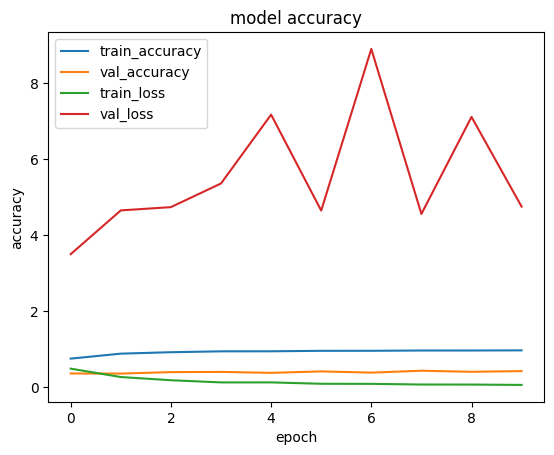

K-Fold Results:
Acuracy: 0.3763594962656498 	 +/- 0.11197604759220521
Precision: 0.27976710721850395 	 +/- 0.05985746166155739
Recall: 0.9030625894665718 	 +/- 0.06947559984244402
AUC: 0.626712029308779 	 +/- 0.12025361276680645
F1: 0.4236565111488326 	 +/- 0.07151471373745477


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.36915239691734314, Test Precision: 0.27321815490722656, Test Recall: 0.969348669052124, Test AUC: 0.748619683235149, Test F1 Score: 0.42628476748846666


In [13]:
# simclr china pretrain deep smote

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_deep_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9703770279884338, Val Precision: 0.9947368502616882, Val Recall: 0.8552036285400391, Val AUC: 0.9980694491596277, Val F1 Score: 0.9197080376740724
Test Accuracy: 0.960629940032959, Test Precision: 0.916190505027771, Test Recall: 0.9214559197425842, Test AUC: 0.9898889895308913,Test F1 Score: 0.9188156688795975

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.962013304233551, Val Precision: 0.995555579662323, Val Recall: 0.8517110347747803, Val AUC: 0.9888674977138182, Val F1 Score: 0.9180328018740079
Test Accuracy: 0.9657248854637146, Test Precision: 0.9552845358848572, Test Recall: 0.9003831148147583, Test AUC: 0.9887760762257846,Test F1 Score: 0.9270216739835919

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9064272046089172, Val Precision: 0.8656716346740723, Val Recall: 0.7864406704902649, Val AUC: 0.9537508052513

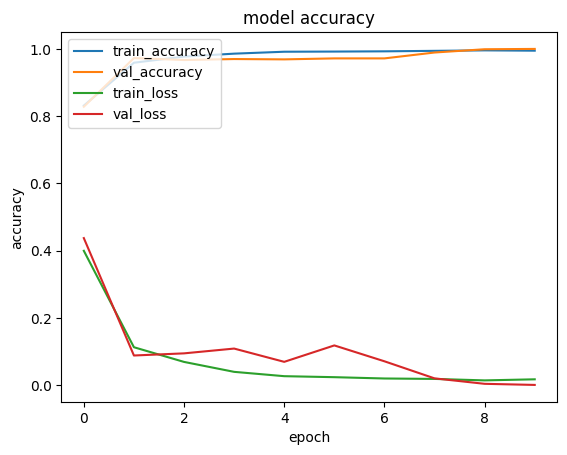

K-Fold Results:
Acuracy: 0.9519234672188759 	 +/- 0.028073575378653647
Precision: 0.9647773578763008 	 +/- 0.05249026340802937
Recall: 0.8498295396566391 	 +/- 0.10186758998437612
AUC: 0.9821040135857 	 +/- 0.01882497586775002
F1: 0.8992227361113452 	 +/- 0.06028743877222666


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9647985100746155, Test Precision: 0.9114391207695007, Test Recall: 0.946360170841217, Test AUC: 0.9858317125289932, Test F1 Score: 0.9285714403464543


In [14]:
# moco china pretrain no smote

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.96499103307724, Val Precision: 0.9136363863945007, Val Recall: 0.9095022678375244, Val AUC: 0.9954497778093061, Val F1 Score: 0.9115646398871494
Test Accuracy: 0.9638721346855164, Test Precision: 0.8881118893623352, Test Recall: 0.9731800556182861, Test AUC: 0.9888439510645818,Test F1 Score: 0.9287020020858652

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.962013304233551, Val Precision: 0.9911894202232361, Val Recall: 0.855513334274292, Val AUC: 0.9766135630745536, Val F1 Score: 0.9183673590429121
Test Accuracy: 0.9555349946022034, Test Precision: 0.8915441036224365, Test Recall: 0.9291187524795532, Test AUC: 0.988274036469853,Test F1 Score: 0.9099436972220817

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.946124792098999, Val Precision: 0.9190140962600708, Val Recall: 0.8847457766532898, Val AUC: 0.968098718261989

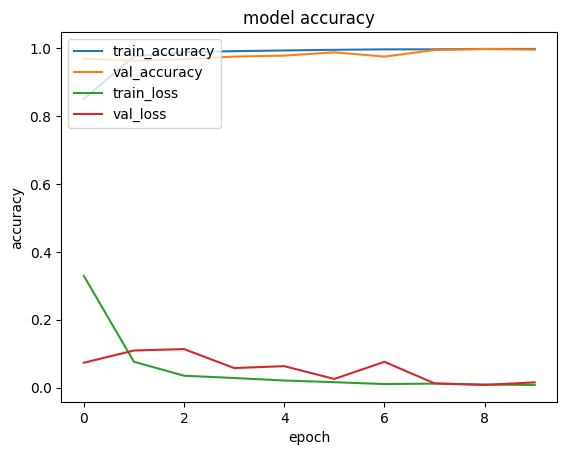

K-Fold Results:
Acuracy: 0.9630181789398193 	 +/- 0.021698488301254974
Precision: 0.9384241253137589 	 +/- 0.07238887432506828
Recall: 0.9215809404850006 	 +/- 0.04850782952648054
AUC: 0.9881971381687257 	 +/- 0.011182866288121844
F1: 0.9271802562747726 	 +/- 0.03965840464576324


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9763779640197754, Test Precision: 0.9626718759536743, Test Recall: 0.938697338104248, Test AUC: 0.9918971485546171, Test F1 Score: 0.9505334584616961


In [15]:
# moco china pretrain smote

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9676840305328369, Val Precision: 0.9894179701805115, Val Recall: 0.8461538553237915, Val AUC: 0.9985305518537849, Val F1 Score: 0.912195119103954
Test Accuracy: 0.9634090065956116, Test Precision: 0.9171375036239624, Test Recall: 0.9329501986503601, Test AUC: 0.9873577261460901,Test F1 Score: 0.9249762756044743

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9420702457427979, Val Precision: 0.9072580933570862, Val Recall: 0.855513334274292, Val AUC: 0.9637387495788612, Val F1 Score: 0.8806262506060618
Test Accuracy: 0.9573876857757568, Test Precision: 0.8937729001045227, Test Recall: 0.9348658919334412, Test AUC: 0.9916759702006052,Test F1 Score: 0.9138576771752157

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9319470524787903, Val Precision: 0.8585209250450134, Val Recall: 0.9050847291946411, Val AUC: 0.97155519026

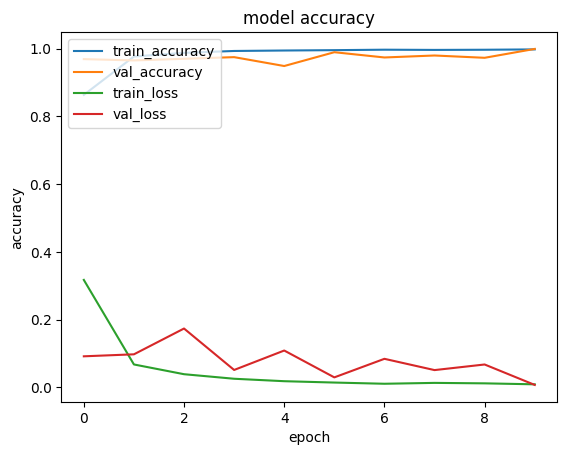

K-Fold Results:
Acuracy: 0.9662047401070595 	 +/- 0.02618519386772321
Precision: 0.9571887776255608 	 +/- 0.04687475048006546
Recall: 0.9135982841253281 	 +/- 0.06671098245979849
AUC: 0.9882542749087542 	 +/- 0.014013586361727191
F1: 0.9335080772062785 	 +/- 0.046406375440543504


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9712830185890198, Test Precision: 0.918181836605072, Test Recall: 0.967432975769043, Test AUC: 0.9925817482217963, Test F1 Score: 0.9421642009329858


In [28]:
# moco china pretrain smote v2 sanity check

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9712746739387512, Val Precision: 0.8953974843025208, Val Recall: 0.9683257937431335, Val AUC: 0.9914696001580924, Val F1 Score: 0.9304347806526717
Test Accuracy: 0.9624826312065125, Test Precision: 0.8705882430076599, Test Recall: 0.992337167263031, Test AUC: 0.9969702076267913,Test F1 Score: 0.9274843385094949

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9221272468566895, Val Precision: 0.773413896560669, Val Recall: 0.9733840227127075, Val AUC: 0.9918371275930115, Val F1 Score: 0.8619528584843877
Test Accuracy: 0.9411764740943909, Test Precision: 0.8043143153190613, Test Recall: 1.0, Test AUC: 0.9976940108646551,Test F1 Score: 0.8915456785885251

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9631379842758179, Val Precision: 0.8926380276679993, Val Recall: 0.9864406585693359, Val AUC: 0.9944243285869783, Val F1 S

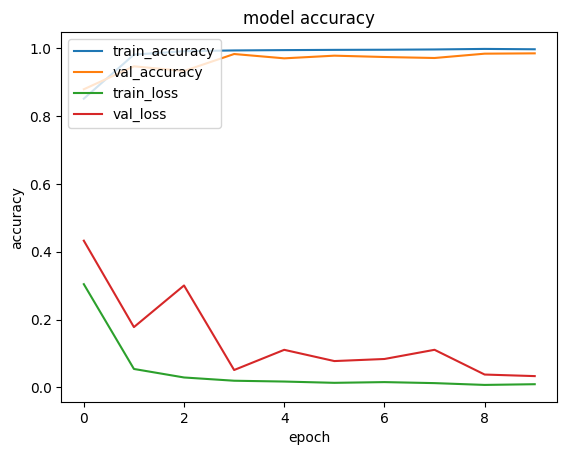

K-Fold Results:
Acuracy: 0.9571049138903618 	 +/- 0.02421944224647009
Precision: 0.9004432857036591 	 +/- 0.06500956584658985
Recall: 0.945980854332447 	 +/- 0.04865400895047024
AUC: 0.9881996836091388 	 +/- 0.012139611101964166
F1: 0.9201691019525766 	 +/- 0.036402953980808346


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9759147763252258, Test Precision: 0.9737903475761414, Test Recall: 0.9252873659133911, Test AUC: 0.9975764001526014, Test F1 Score: 0.948919466813152


In [21]:
# simclr china pretrain smote (8 layers frozen, peformed better than 7)
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9084380865097046, Val Precision: 0.8020304441452026, Val Recall: 0.7149321436882019, Val AUC: 0.9249568032915638, Val F1 Score: 0.7559808650981733
Test Accuracy: 0.8286243677139282, Test Precision: 0.6513944268226624, Test Recall: 0.6264367699623108, Test AUC: 0.883725720116932,Test F1 Score: 0.638671871115548

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7283950448036194, Val Precision: 0.4510638415813446, Val Recall: 0.4030418395996094, Val AUC: 0.6665639890263272, Val F1 Score: 0.42570282458827385
Test Accuracy: 0.8110235929489136, Test Precision: 0.60326087474823, Test Recall: 0.6379310488700867, Test AUC: 0.8377416870876312,Test F1 Score: 0.6201117413792768

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.721172034740448, Val Precision: 0.5, Val Recall: 0.6271186470985413, Val AUC: 0.7237154852611236, Val F1 Sco

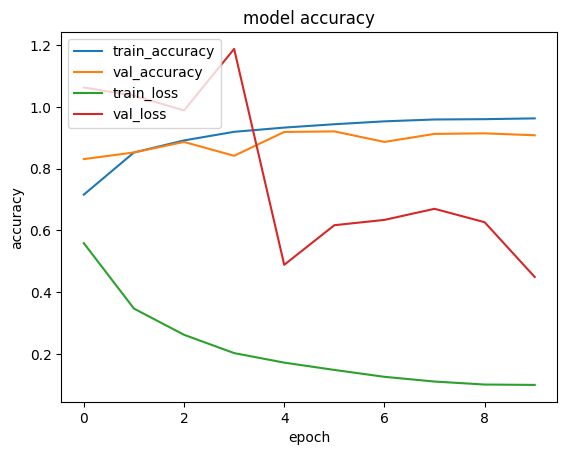

K-Fold Results:
Acuracy: 0.7052297703921795 	 +/- 0.14421655323642374
Precision: 0.47385504096746445 	 +/- 0.1712586554238786
Recall: 0.47670998238027096 	 +/- 0.21984472760431809
AUC: 0.712970382359318 	 +/- 0.10518442150991739
F1: 0.44924373395727946 	 +/- 0.15699375596658666


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.8286243677139282, Test Precision: 0.6513944268226624, Test Recall: 0.6264367699623108, Test AUC: 0.883725720116932, Test F1 Score: 0.638671871115548


In [16]:
# moco china pretrain deep smote

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_deep_smote.h5")

# ROC curves

In [18]:
# load non pre-trained model
X_input = keras.Input(shape=X_train.shape[1:])
model, _ = resnet.model(X_input, num_classes=1, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
a_model = keras.Model(inputs=X_input, outputs=model)
a_model.load_weights('model-weights/fine-tuned/resnet10_no_smote.h5')
a_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


In [19]:
# eval
test_loss, test_accuracy, test_precision, test_recall = a_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}")



Test Accuracy: 0.9555349946022034, Test Precision: 0.8561872839927673, Test Recall: 0.9808428883552551


68/68 [==============================] - 0s 4ms/step
ROC AUC: 0.9837369545730087


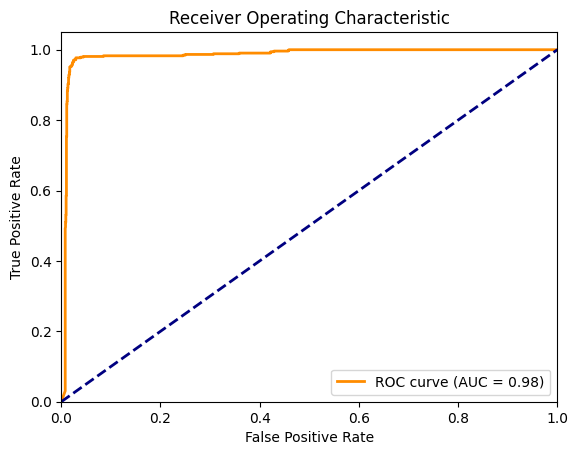

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities for the test set
y_pred_proba = a_model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow import keras

# Function to load a model and get its ROC curve
def load_model_and_get_roc(path, X_test, Y_test):
    # Load the model
    X_input = keras.Input(shape=X_test.shape[1:])
    model, _ = resnet.model(X_input, num_classes=1, filters=[16, 16], kernels=[5, 3], layers=10, hidden_units=128)
    a_model = keras.Model(inputs=X_input, outputs=model)
    a_model.load_weights(path)
    a_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', 'Precision', 'Recall'])
    
    # Predict probabilities
    y_pred_proba = a_model.predict(X_test)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # print acc, f1 and auc
    test_loss, test_accuracy, test_precision, test_recall = a_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1 Score: {test_f1}, Test AUC: {roc_auc}")
    
    return fpr, tpr, roc_auc

68/68 [==============================] - 0s 3ms/step
Test Accuracy: 0.9481241106987, Test Precision: 0.8740875720977783, Test Recall: 0.9176245331764221, Test F1 Score: 0.8953270985226575
68/68 [==============================] - 0s 3ms/step
Test Accuracy: 0.983788788318634, Test Precision: 0.976516604423523, Test Recall: 0.9559386968612671, Test F1 Score: 0.9661180878806175
68/68 [==============================] - 0s 3ms/step
Test Accuracy: 0.9759147763252258, Test Precision: 0.9737903475761414, Test Recall: 0.9252873659133911, Test F1 Score: 0.948919466813152
68/68 [==============================] - 1s 3ms/step
Test Accuracy: 0.9712830185890198, Test Precision: 0.918181836605072, Test Recall: 0.967432975769043, Test F1 Score: 0.9421642009329858


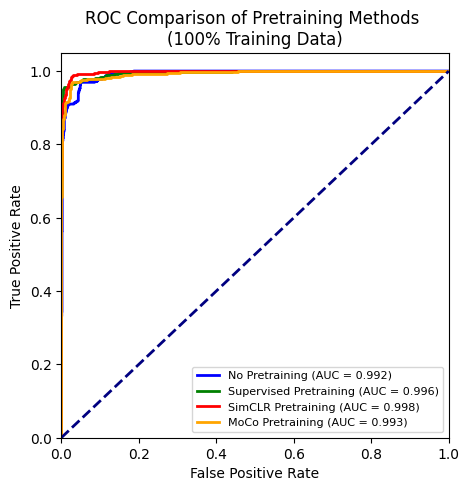

In [22]:
# smote 100%

path_a = 'model-weights/fine-tuned/resnet10_smote.h5' # no pretrain
path_b = 'model-weights/fine-tuned/resnet10_smote_transfer_rbbb.h5' # supervise
path_c = 'model-weights/fine-tuned/resnet10_china_pretrain_moco_smote.h5' # moco
path_d = 'model-weights/fine-tuned/resnet10_china_pretrain_smote.h5' # simclr

fpr_no, tpr_no, auc_no = load_model_and_get_roc(path_a, X_test, Y_test)
fpr_sup, tpr_sup, auc_sup = load_model_and_get_roc(path_b, X_test, Y_test)
fpr_sim, tpr_sim, auc_sim = load_model_and_get_roc(path_d, X_test, Y_test)
fpr_moco, tpr_moco, auc_moco = load_model_and_get_roc(path_c, X_test, Y_test)

plt.figure(figsize=(5, 5))

# ROC for No Pretraining
plt.plot(fpr_no, tpr_no, color='blue', lw=2, label=f'No Pretraining (AUC = {auc_no:.3f})')

# ROC for Supervised Pretraining
plt.plot(fpr_sup, tpr_sup, color='green', lw=2, label=f'Supervised Pretraining (AUC = 0.996)')

# ROC for SimCLR Pretraining
plt.plot(fpr_sim, tpr_sim, color='red', lw=2, label=f'SimCLR Pretraining (AUC = {auc_sim:.3f})')

# ROC for MoCo Pretraining
plt.plot(fpr_moco, tpr_moco, color='orange', lw=2, label=f'MoCo Pretraining (AUC = {auc_moco:.3f})')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Comparison of Pretraining Methods \n(100% Training Data)')
plt.legend(loc='lower right', fontsize=8)
plt.savefig('images/roc-percentages/roc_1.000_smote.png')
plt.show()

68/68 [==============================] - 0s 3ms/step
Test Accuracy: 0.9634090065956116, Test Precision: 0.9049360156059265, Test Recall: 0.9482758641242981, Test F1 Score: 0.9260991595853882
68/68 [==============================] - 0s 2ms/step
Test Accuracy: 0.9578508734703064, Test Precision: 0.8882882595062256, Test Recall: 0.9444444179534912, Test F1 Score: 0.9155060075505385
68/68 [==============================] - 0s 2ms/step
Test Accuracy: 0.9527559280395508, Test Precision: 0.8932584524154663, Test Recall: 0.9137930870056152, Test F1 Score: 0.9034090958889723
68/68 [==============================] - 0s 3ms/step
Test Accuracy: 0.9647985100746155, Test Precision: 0.9114391207695007, Test Recall: 0.946360170841217, Test F1 Score: 0.9285714403464543


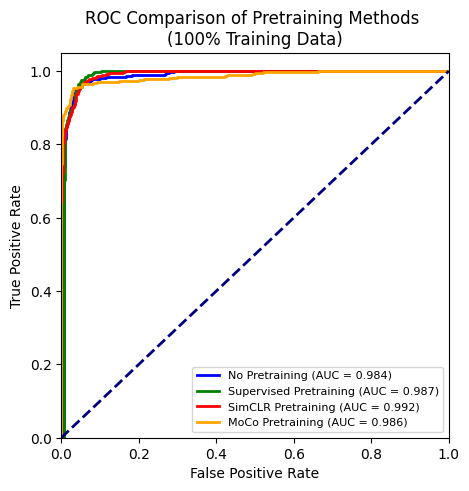

In [21]:
# no smote 100%
path_a = 'model-weights/fine-tuned/resnet10_no_smote2.h5' # no pretrain
path_b = 'model-weights/fine-tuned/resnet10_no_smote_transfer_rbbb.h5' # supervise
path_c = 'model-weights/fine-tuned/resnet10_china_pretrain_moco_no_smote.h5' # moco
path_d = 'model-weights/fine-tuned/resnet10_simclr_china_no_smote2.h5' # simclr

fpr_no, tpr_no, auc_no = load_model_and_get_roc(path_a, X_test, Y_test)
fpr_sup, tpr_sup, auc_sup = load_model_and_get_roc(path_b, X_test, Y_test)
fpr_sim, tpr_sim, auc_sim = load_model_and_get_roc(path_d, X_test, Y_test)
fpr_moco, tpr_moco, auc_moco = load_model_and_get_roc(path_c, X_test, Y_test)

plt.figure(figsize=(5, 5))

# ROC for No Pretraining
plt.plot(fpr_no, tpr_no, color='blue', lw=2, label=f'No Pretraining (AUC = 0.984)')

# ROC for Supervised Pretraining
plt.plot(fpr_sup, tpr_sup, color='green', lw=2, label=f'Supervised Pretraining (AUC = {auc_sup:.3f})')

# ROC for SimCLR Pretraining
plt.plot(fpr_sim, tpr_sim, color='red', lw=2, label=f'SimCLR Pretraining (AUC = 0.992)')

# ROC for MoCo Pretraining
plt.plot(fpr_moco, tpr_moco, color='orange', lw=2, label=f'MoCo Pretraining (AUC = {auc_moco:.3f})')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Comparison of Pretraining Methods \n(100% Training Data)')
plt.legend(loc='lower right', fontsize=8)
plt.savefig('images/roc-percentages/roc_1.000_no_smote.png')
plt.show()

# Expirementing with heavier test:train ratio


In [3]:
def k_fold_finetune_resnet2(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data, experimenting with different fractions of training data."""
    
    X_input = keras.Input(shape=X_train.shape[1:])
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    data_fractions = [i / 8 for i in range(1, 9)]  # Fractions: 1/8, 2/8, ..., 8/8
    results_by_fraction = {}  # Store results for each data fraction
    
    for frac in data_fractions:
        print(f"\n=== Training with {frac*100:.2f}% of the training data ===\n")
        
        val_accuracies = []
        val_precisions = []
        val_recalls = []
        val_f1s = []
        val_aucs = []
        final_history = None

        for i in range(k):
            train_index = np.where(folds_train != i)[0]
            val_index = np.where(folds_val == i)[0]
            
            # Select the fraction of training data
            num_samples = int(len(train_index) * frac)
            train_index_frac = train_index[:num_samples]
            
            X_train_fold, X_val_fold = X_train[train_index_frac], X_val[val_index]
            Y_train_fold, Y_val_fold = Y_train[train_index_frac], Y_val[val_index]
            
            print(f"\nTraining on fold {i+1} with {num_samples} samples")
            
            # make model
            out, _ = resnet.model(X_input, num_classes=num_classes, filters=[16, 16], kernels=[5, 3], layers=10, hidden_units=128)
            fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    
            # load + freeze weights
            if weights_path:
                fine_tuned_model.load_weights(weights_path, by_name=True)
                for layer in fine_tuned_model.layers:
                    if any([text in layer.name for text in layers_to_freeze_substrings]):
                        layer.trainable = False
                    
            # train
            data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
            history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=len(train_index_frac)//batch_size, verbose=0)
            
            # evaluate
            val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
            y_pred = fine_tuned_model.predict(X_val_fold)
            val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
            val_auc = roc_auc_score(Y_val_fold, y_pred)
            
            print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
            
            if not val_f1s or val_f1 > max(val_f1s):
                fine_tuned_model.save_weights(f'model-weights/fine-tuned2/{frac:.3f}_{name}')
                final_history = history
            
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            val_aucs.append(val_auc)
        
        # Store the results for this fraction
        results_by_fraction[frac] = {
            "accuracy": np.mean(val_accuracies),
            "precision": np.mean(val_precisions),
            "recall": np.mean(val_recalls),
            "f1": np.mean(val_f1s),
            "auc": np.mean(val_aucs)
        }
        
        print(f"\nResults for {frac*100:.2f}% training data:")
        print(f"Accuracy: {np.mean(val_accuracies):.4f} +/- {np.std(val_accuracies):.4f}")
        print(f"Precision: {np.mean(val_precisions):.4f} +/- {np.std(val_precisions):.4f}")
        print(f"Recall: {np.mean(val_recalls):.4f} +/- {np.std(val_recalls):.4f}")
        print(f"F1: {np.mean(val_f1s):.4f} +/- {np.std(val_f1s):.4f}")
        print(f"AUC: {np.mean(val_aucs):.4f} +/- {np.std(val_aucs):.4f}")

    # Return or print final results across different data fractions
    return results_by_fraction


In [16]:
# Test finetuning with different amounts of training data:

# no smote, no pretraining
results_no_smote = k_fold_finetune_resnet2(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="no_pretrain_no_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 909 samples
35/35 [==============================] - 0s 4ms/step
Val Accuracy: 0.833034098148346, Val Precision: 0.5799086689949036, Val Recall: 0.5746606588363647, Val AUC: 0.708699639731851, Val F1 Score: 0.5772727366930932

Training on fold 2 with 916 samples
33/33 [==============================] - 0s 4ms/step
Val Accuracy: 0.833808183670044, Val Precision: 0.7018348574638367, Val Recall: 0.5817490220069885, Val AUC: 0.8014775954180102, Val F1 Score: 0.6361746177559117

Training on fold 3 with 916 samples
34/34 [==============================] - 0s 4ms/step
Val Accuracy: 0.7315689921379089, Val Precision: 0.540145993232727, Val Recall: 0.2508474588394165, Val AUC: 0.6500166603727481, Val F1 Score: 0.34259259529841046

Training on fold 4 with 927 samples
31/31 [==============================] - 0s 3ms/step
Val Accuracy: 0.827479362487793, Val Precision: 0.7957746386528015, Val Recall: 0.674626886844635, Val

In [17]:
# no smote, supervised pretraining
results_supervised_no_smote = k_fold_finetune_resnet2(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="supervised_no_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 909 samples
35/35 [==============================] - 0s 4ms/step
Val Accuracy: 0.9174147248268127, Val Precision: 0.88165682554245, Val Recall: 0.6742081642150879, Val AUC: 0.8538355130147504, Val F1 Score: 0.764102584388521

Training on fold 2 with 916 samples
33/33 [==============================] - 0s 5ms/step
Val Accuracy: 0.9135802388191223, Val Precision: 0.9300000071525574, Val Recall: 0.7072243094444275, Val AUC: 0.9121336092794918, Val F1 Score: 0.8034557099773182

Training on fold 3 with 916 samples
34/34 [==============================] - 0s 4ms/step
Val Accuracy: 0.8591682314872742, Val Precision: 0.8476190567016602, Val Recall: 0.6033898591995239, Val AUC: 0.9352311349045915, Val F1 Score: 0.70495051777184

Training on fold 4 with 927 samples
31/31 [==============================] - 1s 5ms/step
Val Accuracy: 0.8667355179786682, Val Precision: 0.8198757767677307, Val Recall: 0.7880597114562988, Val

In [18]:
# no smote, simclr pretraining
results_simclr_no_smote = k_fold_finetune_resnet2(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="simclr_no_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 909 samples
35/35 [==============================] - 0s 4ms/step
Val Accuracy: 0.7836624979972839, Val Precision: 0.47560974955558777, Val Recall: 0.8823529481887817, Val AUC: 0.8916560680607845, Val F1 Score: 0.618066557210689

Training on fold 2 with 916 samples
33/33 [==============================] - 0s 4ms/step
Val Accuracy: 0.8129155039787292, Val Precision: 0.6586538553237915, Val Recall: 0.5209125280380249, Val AUC: 0.8228762574000097, Val F1 Score: 0.5817409680680363

Training on fold 3 with 916 samples
34/34 [==============================] - 0s 4ms/step
Val Accuracy: 0.7268431186676025, Val Precision: 0.5111111402511597, Val Recall: 0.4677966237068176, Val AUC: 0.7469844725325988, Val F1 Score: 0.4884955959113185

Training on fold 4 with 927 samples
31/31 [==============================] - 0s 4ms/step
Val Accuracy: 0.7262396812438965, Val Precision: 0.6073619723320007, Val Recall: 0.5910447835922241

In [19]:
# no smote, moco pretraining
results_moco_no_smote = k_fold_finetune_resnet2(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="moco_no_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 909 samples
35/35 [==============================] - 1s 5ms/step
Val Accuracy: 0.8438060879707336, Val Precision: 0.6441717743873596, Val Recall: 0.4751131236553192, Val AUC: 0.7116765389935801, Val F1 Score: 0.5468749992695747

Training on fold 2 with 916 samples
33/33 [==============================] - 0s 4ms/step
Val Accuracy: 0.7179487347602844, Val Precision: 0.3692307770252228, Val Recall: 0.18250951170921326, Val AUC: 0.6060836501901141, Val F1 Score: 0.24427481624537337

Training on fold 3 with 916 samples
34/34 [==============================] - 0s 4ms/step
Val Accuracy: 0.7192816734313965, Val Precision: 0.4947916567325592, Val Recall: 0.32203391194343567, Val AUC: 0.5725703623075726, Val F1 Score: 0.3901437440868453

Training on fold 4 with 927 samples
31/31 [==============================] - 2s 4ms/step
Val Accuracy: 0.7551652789115906, Val Precision: 0.7168141603469849, Val Recall: 0.4835820794105

In [10]:
# smote, no pretraining
results_smote = k_fold_finetune_resnet2(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="no_pretrain_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 1344 samples
35/35 [==============================] - 0s 4ms/step
Val Accuracy: 0.7836624979972839, Val Precision: 0.4583333432674408, Val Recall: 0.4977375566959381, Val AUC: 0.6058078671213509, Val F1 Score: 0.47722343277879264

Training on fold 2 with 1370 samples
33/33 [==============================] - 0s 4ms/step
Val Accuracy: 0.7730294466018677, Val Precision: 1.0, Val Recall: 0.09125475585460663, Val AUC: 0.8368147470760938, Val F1 Score: 0.16724739180291823

Training on fold 3 with 1377 samples
34/34 [==============================] - 0s 3ms/step
Val Accuracy: 0.8620038032531738, Val Precision: 0.7411003112792969, Val Recall: 0.7762711644172668, Val AUC: 0.9227847257702645, Val F1 Score: 0.758278128726104

Training on fold 4 with 1409 samples
31/31 [==============================] - 0s 4ms/step
Val Accuracy: 0.7716942429542542, Val Precision: 0.8518518805503845, Val Recall: 0.4119403064250946, Val AUC

In [11]:
# smote, supervised pretraining
results_supervised_smote = k_fold_finetune_resnet2(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="supervised_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 1344 samples
35/35 [==============================] - 0s 4ms/step
Val Accuracy: 0.9075403809547424, Val Precision: 0.8597561120986938, Val Recall: 0.6380090713500977, Val AUC: 0.8918334152508448, Val F1 Score: 0.7324675519624434

Training on fold 2 with 1370 samples
33/33 [==============================] - 0s 4ms/step
Val Accuracy: 0.9525166153907776, Val Precision: 0.9650654792785645, Val Recall: 0.8403041958808899, Val AUC: 0.9856812821870338, Val F1 Score: 0.898373981457238

Training on fold 3 with 1377 samples
34/34 [==============================] - 0s 4ms/step
Val Accuracy: 0.7901701331138611, Val Precision: 0.6815920472145081, Val Recall: 0.4644067883491516, Val AUC: 0.8482950885221139, Val F1 Score: 0.5524193634202512

Training on fold 4 with 1409 samples
31/31 [==============================] - 0s 4ms/step
Val Accuracy: 0.9018595218658447, Val Precision: 0.8278688788414001, Val Recall: 0.9044775962829

In [12]:
# smote, simclr pretraining
results_simclr_smote = k_fold_finetune_resnet2(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="simclr_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 1344 samples
35/35 [==============================] - 0s 4ms/step
Val Accuracy: 0.9201077222824097, Val Precision: 0.8473684191703796, Val Recall: 0.7285068035125732, Val AUC: 0.8887982447695246, Val F1 Score: 0.7834549963877586

Training on fold 2 with 1370 samples
33/33 [==============================] - 0s 4ms/step
Val Accuracy: 0.8974359035491943, Val Precision: 0.7881041169166565, Val Recall: 0.8060836791992188, Val AUC: 0.9452664003465371, Val F1 Score: 0.7969925095450346

Training on fold 3 with 1377 samples
34/34 [==============================] - 0s 4ms/step
Val Accuracy: 0.8431001901626587, Val Precision: 0.8056871891021729, Val Recall: 0.5762711763381958, Val AUC: 0.9004376124575161, Val F1 Score: 0.6719367469172252

Training on fold 4 with 1409 samples
31/31 [==============================] - 0s 4ms/step
Val Accuracy: 0.76962810754776, Val Precision: 0.7043795585632324, Val Recall: 0.57611942291259

In [13]:
# smote, moco pretraining
results_moco_smote = k_fold_finetune_resnet2(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="moco_smote.h5")


=== Training with 12.50% of the training data ===


Training on fold 1 with 1344 samples
35/35 [==============================] - 0s 4ms/step
Val Accuracy: 0.89497309923172, Val Precision: 0.8023256063461304, Val Recall: 0.6244344115257263, Val AUC: 0.763140160017836, Val F1 Score: 0.7022901000520809

Training on fold 2 with 1370 samples
33/33 [==============================] - 0s 4ms/step
Val Accuracy: 0.8043684959411621, Val Precision: 0.6647399067878723, Val Recall: 0.4372623562812805, Val AUC: 0.7211002550897627, Val F1 Score: 0.527522942006924

Training on fold 3 with 1377 samples
34/34 [==============================] - 0s 4ms/step
Val Accuracy: 0.778827965259552, Val Precision: 0.6580311059951782, Val Recall: 0.43050846457481384, Val AUC: 0.7144145545016326, Val F1 Score: 0.5204918015724732

Training on fold 4 with 1409 samples
31/31 [==============================] - 0s 4ms/step
Val Accuracy: 0.8471074104309082, Val Precision: 0.8045602440834045, Val Recall: 0.737313449382782,

2024-11-12 20:38:29.586260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-12 20:38:29.733745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-12 20:38:29.733948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-12 20:38:29.734598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

44/68 [==================>...........] - ETA: 0s

2024-11-12 20:38:32.323223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


68/68 [==============================] - 2s 5ms/step
Test Accuracy: 0.8707734942436218, Test Precision: 0.7913669347763062, Test Recall: 0.6321839094161987, Test F1 Score: 0.7028754113708997, Test AUC: 0.8694404070617919
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.8545622825622559, Test Precision: 0.782608687877655, Test Recall: 0.5517241358757019, Test F1 Score: 0.6471910071634852, Test AUC: 0.9273434958350594
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.7522000670433044, Test Precision: 0.49154746532440186, Test Recall: 0.7241379022598267, Test F1 Score: 0.5855925552653087, Test AUC: 0.795267251326485
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.7739694118499756, Test Precision: 0.543367326259613, Test Recall: 0.4080459773540497, Test F1 Score: 0.46608314360063485, Test AUC: 0.761037267967523


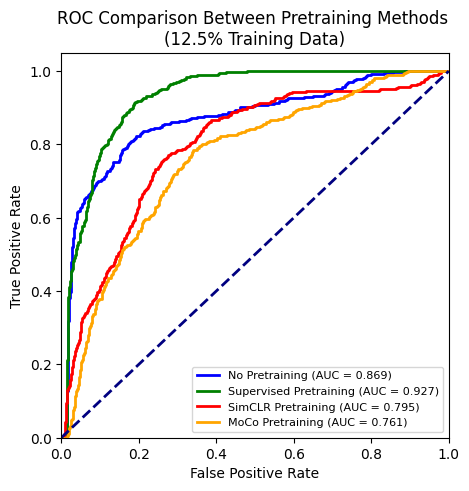

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.8814265727996826, Test Precision: 0.7995495200157166, Test Recall: 0.6800765991210938, Test F1 Score: 0.7349896184833627, Test AUC: 0.9208310220780467
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9397869110107422, Test Precision: 0.8798449635505676, Test Recall: 0.8697317838668823, Test F1 Score: 0.8747591448099454, Test AUC: 0.9626916586504142
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.804539144039154, Test Precision: 0.557208240032196, Test Recall: 0.9329501986503601, Test F1 Score: 0.6977077399732745, Test AUC: 0.9516696040088283
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.8962482810020447, Test Precision: 0.7689530849456787, Test Recall: 0.8160919547080994, Test F1 Score: 0.7918215703311687, Test AUC: 0.9353047463236412


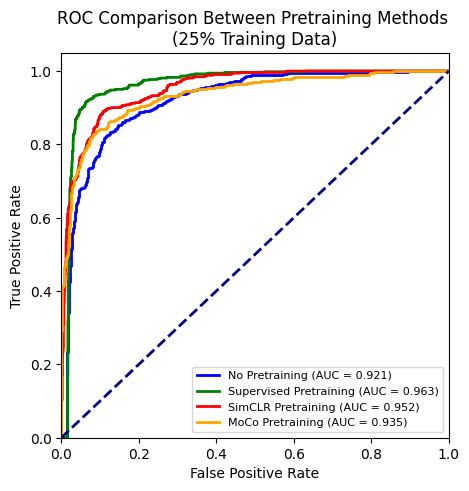

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9462714195251465, Test Precision: 0.8440678119659424, Test Recall: 0.954023003578186, Test F1 Score: 0.8956834685257347, Test AUC: 0.9861090631633888
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9115331172943115, Test Precision: 0.7519025802612305, Test Recall: 0.946360170841217, Test F1 Score: 0.8379983060336752, Test AUC: 0.9494888322485061
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9309865832328796, Test Precision: 0.8693069219589233, Test Recall: 0.8409961462020874, Test F1 Score: 0.8549172188767048, Test AUC: 0.9717710885953887
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9328392744064331, Test Precision: 0.9106754064559937, Test Recall: 0.8007662892341614, Test F1 Score: 0.8521916554457971, Test AUC: 0.9743433109346367


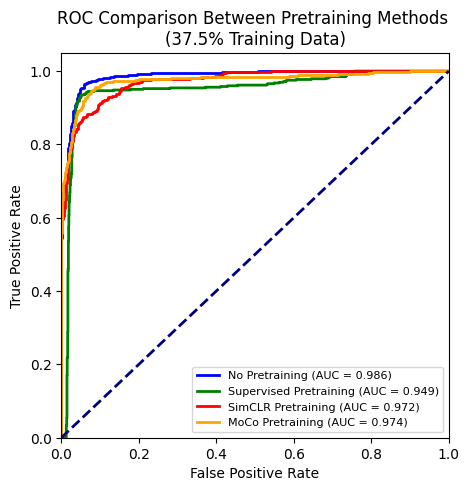

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9245020747184753, Test Precision: 0.804753839969635, Test Recall: 0.9080459475517273, Test F1 Score: 0.8532853267323333, Test AUC: 0.9698126654449196
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9471977949142456, Test Precision: 0.8763837814331055, Test Recall: 0.9099617004394531, Test F1 Score: 0.8928571590244267, Test AUC: 0.9775966221735396
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9309865832328796, Test Precision: 0.8188034296035767, Test Recall: 0.9176245331764221, Test F1 Score: 0.8654019987680078, Test AUC: 0.9757224574436463
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9462714195251465, Test Precision: 0.8612099885940552, Test Recall: 0.9272030591964722, Test F1 Score: 0.8929889401349248, Test AUC: 0.9859206519729343


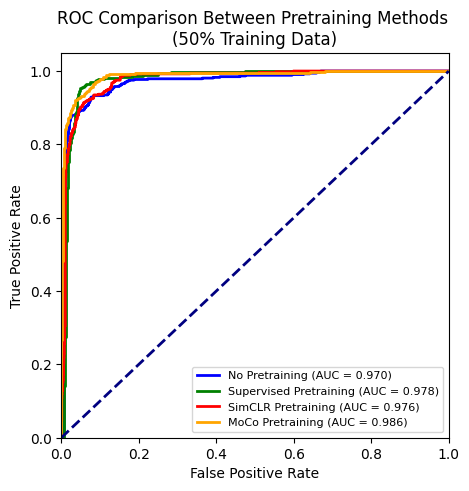

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9694302678108215, Test Precision: 0.9470587968826294, Test Recall: 0.9252873659133911, Test F1 Score: 0.9360465035205144, Test AUC: 0.9860446990921157
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9522927403450012, Test Precision: 0.8915888071060181, Test Recall: 0.9137930870056152, Test F1 Score: 0.9025544025254135, Test AUC: 0.9719103490405073
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9476609826087952, Test Precision: 0.9049504995346069, Test Recall: 0.8754789233207703, Test F1 Score: 0.889970788867946, Test AUC: 0.9868919643212399
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9536822438240051, Test Precision: 0.9073359370231628, Test Recall: 0.9003831148147583, Test F1 Score: 0.9038461549981274, Test AUC: 0.9842799532833868


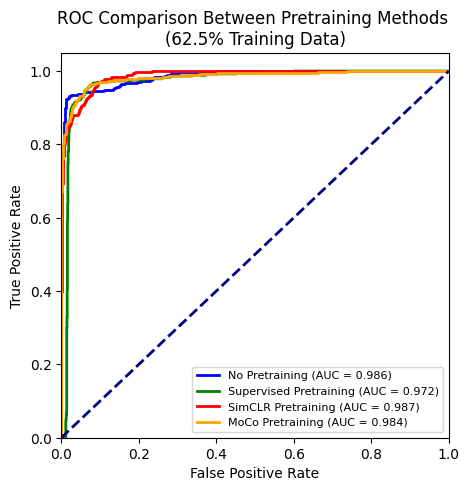

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9397869110107422, Test Precision: 0.8379310369491577, Test Recall: 0.931034505367279, Test F1 Score: 0.8820326793887278, Test AUC: 0.9882576528880744
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9471977949142456, Test Precision: 0.8591549396514893, Test Recall: 0.9348658919334412, Test F1 Score: 0.8954128456320407, Test AUC: 0.9755334611252713
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9708198308944702, Test Precision: 0.921100914478302, Test Recall: 0.961685836315155, Test F1 Score: 0.940955955736799, Test AUC: 0.9935273149415926
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9634090065956116, Test Precision: 0.923518180847168, Test Recall: 0.9252873659133911, Test F1 Score: 0.9244019268835227, Test AUC: 0.9857849022953398


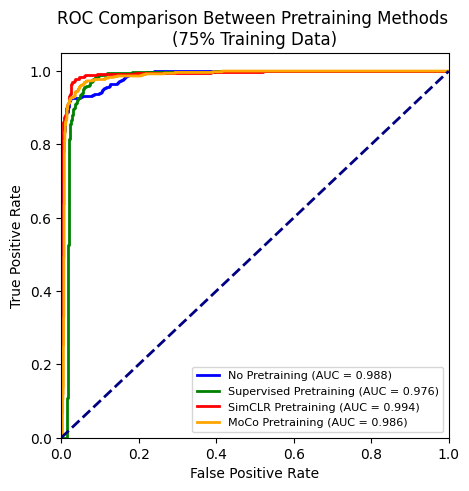

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9615562558174133, Test Precision: 0.905730128288269, Test Recall: 0.938697338104248, Test F1 Score: 0.9219191060171328, Test AUC: 0.9881142965475113
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9546086192131042, Test Precision: 0.8812949657440186, Test Recall: 0.938697338104248, Test F1 Score: 0.9090909194279256, Test AUC: 0.9795357361026267
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9717462062835693, Test Precision: 0.9441233277320862, Test Recall: 0.938697338104248, Test F1 Score: 0.9414025144987139, Test AUC: 0.996369866380188
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9578508734703064, Test Precision: 0.8855098485946655, Test Recall: 0.9482758641242981, Test F1 Score: 0.9158186924923131, Test AUC: 0.9852904692023771


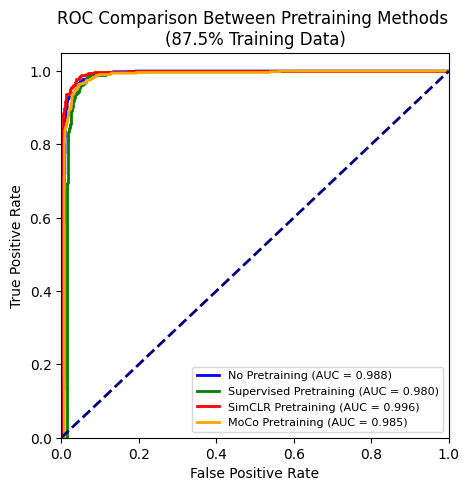

In [ ]:
# plot ROC curves comparing each pretraining method at different data fractions (no smote)

data_fractions = [i / 8 for i in range(1, 8)]
for frac in data_fractions:
    fpr_no, tpr_no, auc_no = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_no_pretrain_no_smote.h5', X_test, Y_test)
    fpr_sup, tpr_sup, auc_sup = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_supervised_no_smote.h5', X_test, Y_test)
    fpr_sim, tpr_sim, auc_sim = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_simclr_no_smote.h5', X_test, Y_test)
    fpr_moco, tpr_moco, auc_moco = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_moco_no_smote.h5', X_test, Y_test)
    
    plt.figure(figsize=(5, 5))
    
    # ROC for No Pretraining
    plt.plot(fpr_no, tpr_no, color='blue', lw=2, label=f'No Pretraining (AUC = {auc_no:.3f})')
    
    # ROC for Supervised Pretraining
    plt.plot(fpr_sup, tpr_sup, color='green', lw=2, label=f'Supervised Pretraining (AUC = {auc_sup:.3f})')
    
    # ROC for SimCLR Pretraining
    plt.plot(fpr_sim, tpr_sim, color='red', lw=2, label=f'SimCLR Pretraining (AUC = {auc_sim:.3f})')
    
    # ROC for MoCo Pretraining
    plt.plot(fpr_moco, tpr_moco, color='orange', lw=2, label=f'MoCo Pretraining (AUC = {auc_moco:.3f})')
    
    # Plot diagonal line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # remove traoiling zeros from frac
    frac_percent = frac * 100
    frac_str = str(frac_percent).rstrip('0').rstrip('.')
    

    plt.title(f'ROC Comparison Between Pretraining Methods \n({frac_str}% Training Data)')
        
    plt.legend(loc='lower right', prop={'size': 8})
    plt.savefig(f'images/roc-percentages/roc_{frac:.3f}_no_smote.png')
    plt.show()
    
    

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9027327299118042, Test Precision: 0.7765957713127136, Test Recall: 0.8390804529190063, Test F1 Score: 0.8066298454542347, Test AUC: 0.8953732765057096
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.8795738816261292, Test Precision: 0.7823275923728943, Test Recall: 0.6954023241996765, Test F1 Score: 0.7363083333705122, Test AUC: 0.9520920663675492
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.8985641598701477, Test Precision: 0.7719928026199341, Test Recall: 0.8237547874450684, Test F1 Score: 0.7970342816001393, Test AUC: 0.9439365534093063
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.8851320147514343, Test Precision: 0.795258641242981, Test Recall: 0.7068965435028076, Test F1 Score: 0.748478706320264, Test AUC: 0.9102437174815158


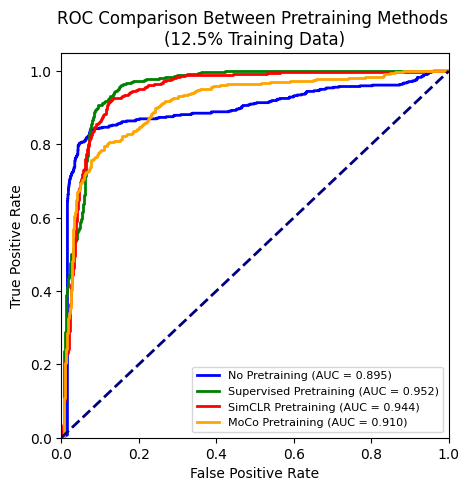

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9064381718635559, Test Precision: 0.7846975326538086, Test Recall: 0.8448275923728943, Test F1 Score: 0.8136531521623568, Test AUC: 0.9543143822102389
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9522927403450012, Test Precision: 0.8886827230453491, Test Recall: 0.9176245331764221, Test F1 Score: 0.9029217660146731, Test AUC: 0.9904834794982879
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9138489961624146, Test Precision: 0.8766816258430481, Test Recall: 0.7490421533584595, Test F1 Score: 0.8078512490649593, Test AUC: 0.9716248066152222
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9430291652679443, Test Precision: 0.9063136577606201, Test Recall: 0.8524904251098633, Test F1 Score: 0.8785784874074817, Test AUC: 0.9695768588928911


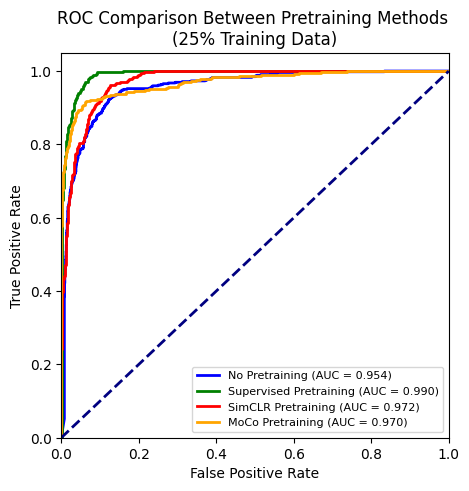

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9407132863998413, Test Precision: 0.8468309640884399, Test Recall: 0.9214559197425842, Test F1 Score: 0.8825687867910229, Test AUC: 0.9798388323655319
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9485872983932495, Test Precision: 0.8650088906288147, Test Recall: 0.9329501986503601, Test F1 Score: 0.897695860999842, Test AUC: 0.9767435056652085
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9490504860877991, Test Precision: 0.891635000705719, Test Recall: 0.8984674215316772, Test F1 Score: 0.8950381722071356, Test AUC: 0.9865830167791282
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9671143889427185, Test Precision: 0.9519038200378418, Test Recall: 0.9099617004394531, Test F1 Score: 0.9304603465822748, Test AUC: 0.9706722183603779


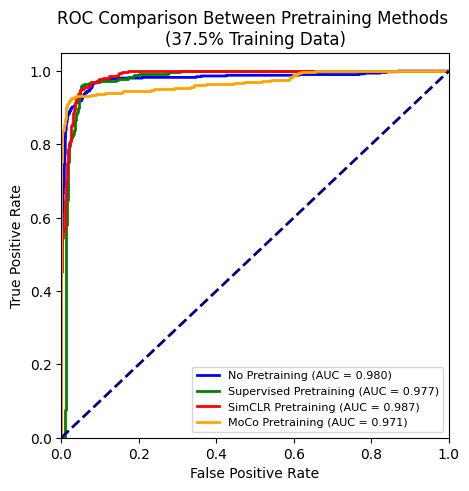

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.925891637802124, Test Precision: 0.7900640964508057, Test Recall: 0.9444444179534912, Test F1 Score: 0.8603839295360263, Test AUC: 0.9672591671991332
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9546086192131042, Test Precision: 0.9030418395996094, Test Recall: 0.9099617004394531, Test F1 Score: 0.9064885641782339, Test AUC: 0.9824327044378444
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.965261697769165, Test Precision: 0.9289827346801758, Test Recall: 0.9272030591964722, Test F1 Score: 0.9280920437788941, Test AUC: 0.9916865025031772
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9416396617889404, Test Precision: 0.84375, Test Recall: 0.931034505367279, Test F1 Score: 0.8852459118591139, Test AUC: 0.9899217566944486


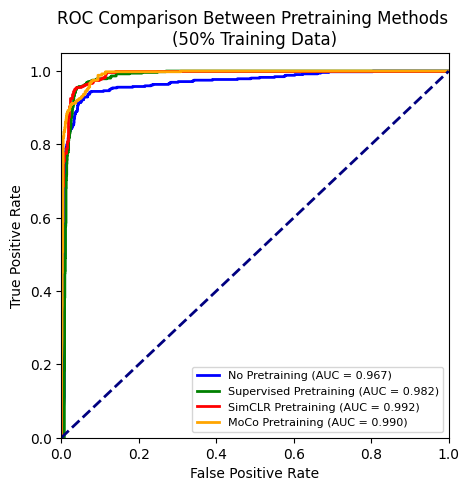

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9689671397209167, Test Precision: 0.943469762802124, Test Recall: 0.9272030591964722, Test F1 Score: 0.935265686273124, Test AUC: 0.9918924675312517
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9671143889427185, Test Precision: 0.9122486114501953, Test Recall: 0.9559386968612671, Test F1 Score: 0.933582778304382, Test AUC: 0.9871576123972223
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9685039520263672, Test Precision: 0.9082733988761902, Test Recall: 0.967432975769043, Test F1 Score: 0.9369202439831231, Test AUC: 0.995604519059957
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.962945818901062, Test Precision: 0.9169811606407166, Test Recall: 0.931034505367279, Test F1 Score: 0.9239543982573026, Test AUC: 0.9924799359636003


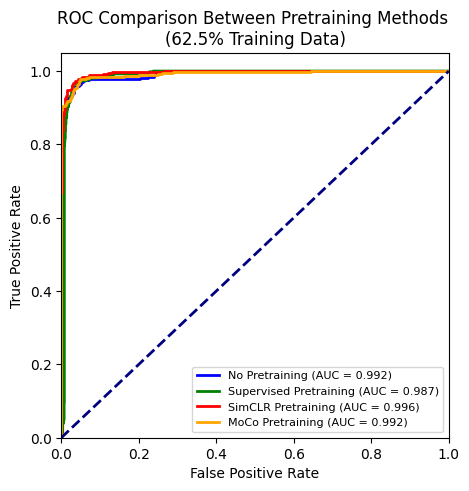

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9481241106987, Test Precision: 0.8824626803398132, Test Recall: 0.9061302542686462, Test F1 Score: 0.894139876599649, Test AUC: 0.9714480979831811
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9647985100746155, Test Precision: 0.9144981503486633, Test Recall: 0.9425287246704102, Test F1 Score: 0.928301886156302, Test AUC: 0.9957519712959647
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.965261697769165, Test Precision: 0.9390962719917297, Test Recall: 0.9157088398933411, Test F1 Score: 0.9272551086509974, Test AUC: 0.990082081744711
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9601667523384094, Test Precision: 0.8949275612831116, Test Recall: 0.946360170841217, Test F1 Score: 0.9199255336473535, Test AUC: 0.9866625941763388


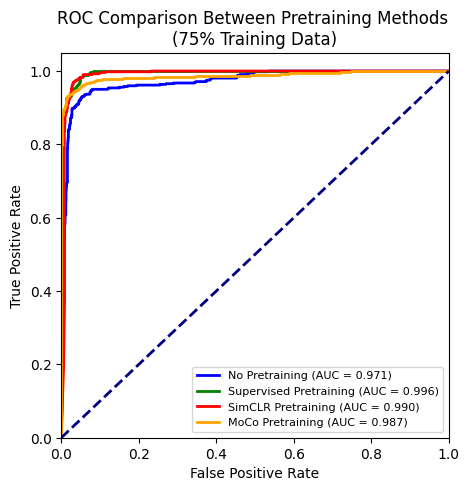

68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9573876857757568, Test Precision: 0.9071969985961914, Test Recall: 0.9176245331764221, Test F1 Score: 0.91238097297902, Test AUC: 0.9816796448039469
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9708198308944702, Test Precision: 0.9456310868263245, Test Recall: 0.9329501986503601, Test F1 Score: 0.9392478431730069, Test AUC: 0.9828967108789324
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.962945818901062, Test Precision: 0.9077490568161011, Test Recall: 0.9425287246704102, Test F1 Score: 0.9248120140688019, Test AUC: 0.9947906061223105
68/68 [==============================] - 1s 4ms/step
Test Accuracy: 0.9759147763252258, Test Precision: 0.9501915574073792, Test Recall: 0.9501915574073792, Test F1 Score: 0.9501915574073792, Test AUC: 0.9957800574361566


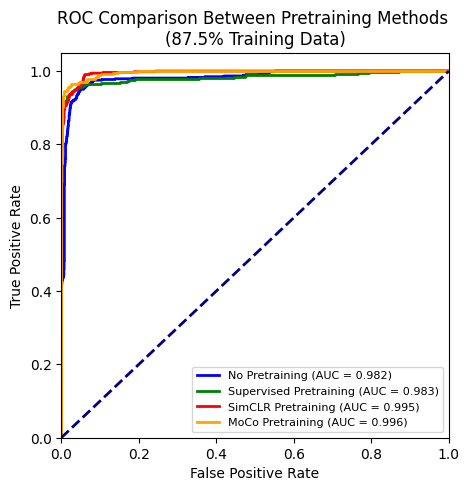

In [6]:
# plot ROC curves comparing each pretraining method at different data fractions (SMOTE)

data_fractions = [i / 8 for i in range(1, 8)]
for frac in data_fractions:
    fpr_no, tpr_no, auc_no = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_no_pretrain_smote.h5', X_test, Y_test)
    fpr_sup, tpr_sup, auc_sup = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_supervised_smote.h5', X_test, Y_test)
    fpr_sim, tpr_sim, auc_sim = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_simclr_smote.h5', X_test, Y_test)
    fpr_moco, tpr_moco, auc_moco = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_moco_smote.h5', X_test, Y_test)
    
    plt.figure(figsize=(5, 5))
    
    # ROC for No Pretraining
    plt.plot(fpr_no, tpr_no, color='blue', lw=2, label=f'No Pretraining (AUC = {auc_no:.3f})')
    
    # ROC for Supervised Pretraining
    plt.plot(fpr_sup, tpr_sup, color='green', lw=2, label=f'Supervised Pretraining (AUC = {auc_sup:.3f})')
    
    # ROC for SimCLR Pretraining
    plt.plot(fpr_sim, tpr_sim, color='red', lw=2, label=f'SimCLR Pretraining (AUC = {auc_sim:.3f})')
    
    # ROC for MoCo Pretraining
    plt.plot(fpr_moco, tpr_moco, color='orange', lw=2, label=f'MoCo Pretraining (AUC = {auc_moco:.3f})')
    
    # Plot diagonal line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # remove traoiling zeros from frac
    frac_percent = frac * 100
    frac_str = str(frac_percent).rstrip('0').rstrip('.')
    

    plt.title(f'ROC Comparison Between Pretraining Methods \n({frac_str}% Training Data)')
    plt.legend(loc='lower right', prop={'size': 8})
    plt.savefig(f'images/roc-percentages/roc_{frac:.3f}_smote.png')
    plt.show()


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8940753936767578, Val Precision: 0.680701732635498, Val Recall: 0.877828061580658, Val AUC: 0.9744011998804173, Val F1 Score: 0.766798407950282
Test Accuracy: 0.9240388870239258, Test Precision: 0.8023648858070374, Test Recall: 0.9099617004394531, Test AUC: 0.9717874721771674,Test F1 Score: 0.8527827830581589

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.924026608467102, Val Precision: 0.808080792427063, Val Recall: 0.9125475287437439, Val AUC: 0.9762092698657169, Val F1 Score: 0.8571428484367016
Test Accuracy: 0.9499768614768982, Test Precision: 0.8484848737716675, Test Recall: 0.9655172228813171, Test AUC: 0.9949913049990989,Test F1 Score: 0.9032258126849805

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9073724150657654, Val Precision: 0.8229508399963379, Val Recall: 0.8508474826812744, Val AUC: 0.94797520936535

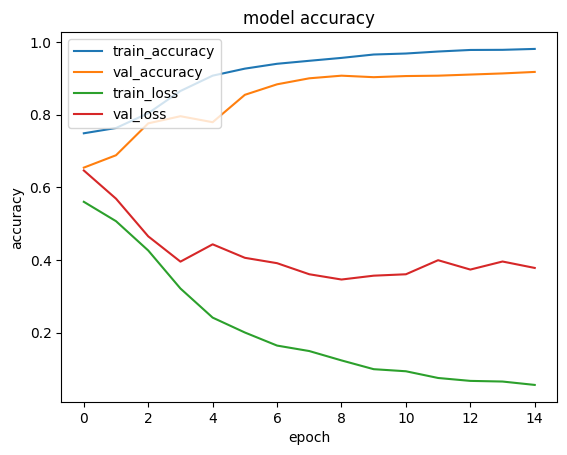

K-Fold Results:
Acuracy: 0.9070236906409264 	 +/- 0.01637373160339144
Precision: 0.7721177339553833 	 +/- 0.07491568964410543
Recall: 0.8928244635462761 	 +/- 0.0653087873144485
AUC: 0.9548257982904756 	 +/- 0.03295005786883812
F1: 0.8241885329658658 	 +/- 0.04292599032116453


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9527559280395508, Test Precision: 0.8932584524154663, Test Recall: 0.9137930870056152, Test AUC: 0.9917941660405798, Test F1 Score: 0.9034090958889723


In [27]:
# simclr china pretrain no smote

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=15, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.0001, num_classes=1, name="resnet10_simclr_china_no_smote2.h5")

In [3]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

alpha = .95
y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
y_pred_2 = np.array([0.18, 0.25, 0.55, 0.35, 0.87, 0.79, 0.88, 0.99, 0.01])
y_true = np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])

print(y_pred.shape, y_pred_2.shape, y_true.shape)

# type of y_true
print(y_true.dtype)

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

p_value = delong_roc_test(y_true, y_pred, y_pred_2)
print('P value:', p_value)
       

(9,) (9,) (9,)
int64
AUC: 0.8
AUC COV: 0.028749999999999998
95% AUC CI: [0.46767194 1.        ]
P value: [[-0.31921128]]


/tmp/ipykernel_4982/3748613858.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_4982/3748613858.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/tmp/ipykernel_4982/3748613858.py:64: DeprecationWarning: `np.float` is a deprecated alias for t

In [29]:
path_og = 'model-weights/fine-tuned/resnet10_no_smote2.h5' # no pretrain no smote
path_a = 'model-weights/fine-tuned/resnet10_smote.h5' # no pretrain
path_b = 'model-weights/fine-tuned/resnet10_smote_transfer_rbbb.h5' # supervise
path_c = 'model-weights/fine-tuned/resnet10_china_pretrain_moco_smote.h5' # moco
path_d = 'model-weights/fine-tuned/resnet10_china_pretrain_smote.h5' # simclr

X_input = keras.Input(shape=X_test.shape[1:])
model, _ = resnet.model(X_input, num_classes=1, filters=[16, 16], kernels=[5, 3], layers=10, hidden_units=128)
model = keras.Model(inputs=X_input, outputs=model)

model.load_weights(path_og)
og_preds = model.predict(X_test)
og_preds = og_preds.reshape(og_preds.shape[0])

model.load_weights(path_a)
a_preds = model.predict(X_test)
a_preds = a_preds.reshape(a_preds.shape[0])

model.load_weights(path_b)
b_preds = model.predict(X_test)
b_preds = b_preds.reshape(b_preds.shape[0])

model.load_weights(path_c)
c_preds = model.predict(X_test)
c_preds = c_preds.reshape(c_preds.shape[0])

model.load_weights(path_d)
d_preds = model.predict(X_test)
d_preds = d_preds.reshape(d_preds.shape[0])


# convert Y-test to int64 (1s and 0s)
Y_test = Y_test.astype(np.int64)



# Compute p-values for each pair of models
p_value_a = delong_roc_test(Y_test, og_preds, a_preds)
p_value_b = delong_roc_test(Y_test, og_preds, b_preds)
p_value_c = delong_roc_test(Y_test, og_preds, c_preds)
p_value_d = delong_roc_test(Y_test, og_preds, d_preds)

# print(f"log(p-value) for No Pretraining vs No Pretraining (SMOTE): {p_value_a}")
# print(f"log(p-value) for No Pretraining vs Supervised Pretraining (SMOTE): {p_value_b}")
# print(f"log(p-value) for No Pretraining vs MoCo Pretraining (SMOTE): {p_value_c}")
# print(f"log(p-value) for No Pretraining vs SimCLR Pretraining (SMOTE): {p_value_d}")

print(f"p-value for No Pretraining vs No Pretraining (SMOTE): {10**p_value_a}")
print(f"p-value for No Pretraining vs Supervised Pretraining (SMOTE): {10**p_value_b}")
print(f"p-value for No Pretraining vs MoCo Pretraining (SMOTE): {10**p_value_c}")
print(f"p-value for No Pretraining vs SimCLR Pretraining (SMOTE): {10**p_value_d}")






68/68 [==============================] - 0s 4ms/step
p-value for No Pretraining vs No Pretraining (SMOTE): [[0.00476954]]
p-value for No Pretraining vs Supervised Pretraining (SMOTE): [[4.29756121e-06]]
p-value for No Pretraining vs MoCo Pretraining (SMOTE): [[0.00247]]
p-value for No Pretraining vs SimCLR Pretraining (SMOTE): [[8.8581008e-07]]


/tmp/ipykernel_4953/3748613858.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_4953/3748613858.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/tmp/ipykernel_4953/3748613858.py:64: DeprecationWarning: `np.float` is a deprecated alias for t

In [40]:
# no smote 100%
path_a_no_smote = 'model-weights/fine-tuned/resnet10_no_smote2.h5' # no pretrain
path_b_no_smote = 'model-weights/fine-tuned/resnet10_no_smote_transfer_rbbb.h5' # supervise
path_c_no_smote = 'model-weights/fine-tuned/resnet10_china_pretrain_moco_no_smote.h5' # moco
path_d_no_smote = 'model-weights/fine-tuned/resnet10_simclr_china_no_smote2.h5' # simclr

# smote 100%
path_a = 'model-weights/fine-tuned/resnet10_smote.h5' # no pretrain
path_b = 'model-weights/fine-tuned/resnet10_smote_transfer_rbbb.h5' # supervise
path_c = 'model-weights/fine-tuned/resnet10_china_pretrain_moco_smote.h5' # moco
path_d = 'model-weights/fine-tuned/resnet10_china_pretrain_smote.h5' # simclr


# data_fractions = [i / 8 for i in range(1, 8)]
# for frac in data_fractions:
#     fpr_no, tpr_no, auc_no = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_no_pretrain_smote.h5', X_test, Y_test)
#     fpr_sup, tpr_sup, auc_sup = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_supervised_smote.h5', X_test, Y_test)
#     fpr_sim, tpr_sim, auc_sim = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_simclr_smote.h5', X_test, Y_test)
#     fpr_moco, tpr_moco, auc_moco = load_model_and_get_roc(f'model-weights/fine-tuned2/{frac:.3f}_moco_smote.h5', X_test, Y_test)
    
data_fractions = [i / 8 for i in range(1, 8)]
no_smote_models = [[f'model-weights/fine-tuned2/{frac:.3f}_no_pretrain_no_smote.h5',
                    f'model-weights/fine-tuned2/{frac:.3f}_supervised_no_smote.h5',
                    f'model-weights/fine-tuned2/{frac:.3f}_simclr_no_smote.h5',
                    f'model-weights/fine-tuned2/{frac:.3f}_moco_no_smote.h5'] for frac in data_fractions]
no_smote_models = [model for sublist in no_smote_models for model in sublist]
no_smote_models.extend([path_a_no_smote, path_b_no_smote, path_c_no_smote, path_d_no_smote])

smote_models = [[f'model-weights/fine-tuned2/{frac:.3f}_no_pretrain_smote.h5', 
                 f'model-weights/fine-tuned2/{frac:.3f}_supervised_smote.h5', 
                 f'model-weights/fine-tuned2/{frac:.3f}_simclr_smote.h5', 
                 f'model-weights/fine-tuned2/{frac:.3f}_moco_smote.h5'] for frac in data_fractions]
# flatten list and append 100% models
smote_models = [model for sublist in smote_models for model in sublist]
smote_models.extend([path_a, path_b, path_c, path_d])

print(smote_models)
print(no_smote_models)

['model-weights/fine-tuned2/0.125_no_pretrain_smote.h5', 'model-weights/fine-tuned2/0.125_supervised_smote.h5', 'model-weights/fine-tuned2/0.125_simclr_smote.h5', 'model-weights/fine-tuned2/0.125_moco_smote.h5', 'model-weights/fine-tuned2/0.250_no_pretrain_smote.h5', 'model-weights/fine-tuned2/0.250_supervised_smote.h5', 'model-weights/fine-tuned2/0.250_simclr_smote.h5', 'model-weights/fine-tuned2/0.250_moco_smote.h5', 'model-weights/fine-tuned2/0.375_no_pretrain_smote.h5', 'model-weights/fine-tuned2/0.375_supervised_smote.h5', 'model-weights/fine-tuned2/0.375_simclr_smote.h5', 'model-weights/fine-tuned2/0.375_moco_smote.h5', 'model-weights/fine-tuned2/0.500_no_pretrain_smote.h5', 'model-weights/fine-tuned2/0.500_supervised_smote.h5', 'model-weights/fine-tuned2/0.500_simclr_smote.h5', 'model-weights/fine-tuned2/0.500_moco_smote.h5', 'model-weights/fine-tuned2/0.625_no_pretrain_smote.h5', 'model-weights/fine-tuned2/0.625_supervised_smote.h5', 'model-weights/fine-tuned2/0.625_simclr_smot

In [36]:
# create a dataframe to store the predictions of each model
df = pd.DataFrame()
df['y_true'] = Y_test

X_input = keras.Input(shape=X_test.shape[1:])
model, _ = resnet.model(X_input, num_classes=1, filters=[16, 16], kernels=[5, 3], layers=10, hidden_units=128)
model = keras.Model(inputs=X_input, outputs=model)

# load each model and get predictions
for path in smote_models:
    # remove folders and extensions from path
    trimmed_path = path.split('/')[-1].split('.h5')[0]
    print(trimmed_path)
    model.load_weights(path)
    preds = model.predict(X_test)
    preds = preds.reshape(preds.shape[0])
    df[trimmed_path] = preds

for path in no_smote_models:
    # remove folders and extensions from path
    trimmed_path = path.split('/')[-1].split('.h5')[0]
    print(trimmed_path)
    model.load_weights(path)
    preds = model.predict(X_test)
    preds = preds.reshape(preds.shape[0])
    df[trimmed_path] = preds


0.125_no_pretrain_smote
68/68 [==============================] - 1s 4ms/step
0.125_supervised_smote
68/68 [==============================] - 0s 4ms/step
0.125_simclr_smote
68/68 [==============================] - 0s 4ms/step
0.125_moco_smote
68/68 [==============================] - 0s 4ms/step
0.250_no_pretrain_smote
68/68 [==============================] - 0s 4ms/step
0.250_supervised_smote
68/68 [==============================] - 0s 4ms/step
0.250_simclr_smote
68/68 [==============================] - 0s 3ms/step
0.250_moco_smote
68/68 [==============================] - 0s 4ms/step
0.375_no_pretrain_smote
68/68 [==============================] - 0s 4ms/step
0.375_supervised_smote
68/68 [==============================] - 0s 4ms/step
0.375_simclr_smote
68/68 [==============================] - 0s 3ms/step
0.375_moco_smote
68/68 [==============================] - 0s 4ms/step
0.500_no_pretrain_smote
68/68 [==============================] - 0s 4ms/step
0.500_supervised_smote
68/68 [========

In [37]:
# save the dataframe to a csv
df.to_csv('predictions.csv', index=False)



In [41]:
df_delongs_results = pd.DataFrame(columns=['model1', 'model2', 'p-value', 'statistaically_significant'])

data_fractions = [i / 8 for i in range(1, 8)]

for frac in data_fractions:
    # get the models for this fraction
    models = [f'{frac:.3f}_supervised_no_smote',
              f'{frac:.3f}_simclr_no_smote',
              f'{frac:.3f}_moco_no_smote',
              f'{frac:.3f}_no_pretrain_smote',
              f'{frac:.3f}_supervised_smote',
              f'{frac:.3f}_simclr_smote',
              f'{frac:.3f}_moco_smote']
    baseline = f'{frac:.3f}_no_pretrain_no_smote'
    
    for model in models:
        p_value = delong_roc_test(df['y_true'], df[baseline], df[model])
        print(f"p-value for {baseline} vs {model}: {10**p_value}")
        statiscally_significant = 10**p_value < 0.05
        df_delongs_results = df_delongs_results.append({'model1': baseline, 'model2': model, 'p-value': 10**p_value, 'statistaically_significant': statiscally_significant}, ignore_index=True)
        
# 100% models

models = ['resnet10_no_smote_transfer_rbbb', 'resnet10_china_pretrain_moco_no_smote', 'resnet10_simclr_china_no_smote2', 'resnet10_smote', 'resnet10_smote_transfer_rbbb', 'resnet10_china_pretrain_moco_smote', 'resnet10_china_pretrain_smote']
baseline = 'resnet10_no_smote2'

for model in models:
    p_value = delong_roc_test(df['y_true'], df[baseline], df[model])
    print(f"p-value for {baseline} vs {model}: {10**p_value}")
    statiscally_significant = 10**p_value < 0.05
    df_delongs_results = df_delongs_results.append({'model1': baseline, 'model2': model, 'p-value': 10**p_value, 'statistaically_significant': statiscally_significant}, ignore_index=True)
    
df_delongs_results.to_csv('delongs_results.csv', index=False)
    
    
    

/tmp/ipykernel_4953/3748613858.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_4953/3748613858.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/tmp/ipykernel_4953/3748613858.py:64: DeprecationWarning: `np.float` is a deprecated alias for t

p-value for 0.125_no_pretrain_no_smote vs 0.125_supervised_no_smote: [[1.57020985e-09]]
p-value for 0.125_no_pretrain_no_smote vs 0.125_simclr_no_smote: [[2.22130777e-08]]
p-value for 0.125_no_pretrain_no_smote vs 0.125_moco_no_smote: [[1.15717012e-23]]
p-value for 0.125_no_pretrain_no_smote vs 0.125_no_pretrain_smote: [[3.03042782e-05]]
p-value for 0.125_no_pretrain_no_smote vs 0.125_supervised_smote: [[3.13634626e-20]]
p-value for 0.125_no_pretrain_no_smote vs 0.125_simclr_smote: [[1.22087357e-15]]
p-value for 0.125_no_pretrain_no_smote vs 0.125_moco_smote: [[1.4499965e-07]]
p-value for 0.250_no_pretrain_no_smote vs 0.250_supervised_no_smote: [[6.11144399e-13]]
p-value for 0.250_no_pretrain_no_smote vs 0.250_simclr_no_smote: [[2.34112705e-06]]
p-value for 0.250_no_pretrain_no_smote vs 0.250_moco_no_smote: [[0.03367041]]
p-value for 0.250_no_pretrain_no_smote vs 0.250_no_pretrain_smote: [[1.07195329e-07]]
p-value for 0.250_no_pretrain_no_smote vs 0.250_supervised_smote: [[3.12435278e-

/tmp/ipykernel_4953/3496485720.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_delongs_results = df_delongs_results.append({'model1': baseline, 'model2': model, 'p-value': 10**p_value, 'statistaically_significant': statiscally_significant}, ignore_index=True)
/tmp/ipykernel_4953/3748613858.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_4953/3748613858.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify 

In [21]:
# compare other models to the baseline model

# models = ["model-weights/fine-tuned/resnet10_no_smote_transfer.h5", "model resnet10_no_smote_transfer2-weights/fine-tuned/resnet10_smote_transfer.h5", "model-weights/fine-tuned/resnet10_bard_SimCLR_no_smote_brugada.h5", "model-weights/fine-tuned/resnet10_bard_SimCLR_smote_brugada.h5", "model-weights/fine-tuned/resnet10_ptbxl_SimCLR_no_smote_brugada.h5", "model-weights/fine-tuned/moco_bard_no_smote.h5", "model-weights/fine-tuned/resnet10_bard_SimCLR_smote_brugada.h5", "model-weights/fine-tuned/resnet10_bard_moco_no_smote_brugada.h5", "model-weights/fine-tuned/resnet10_bard_moco_smote_brugada.h5"]
# models = ["model-weights/fine-tuned/resnet10_no_smote_transfer.h5"]
# models = ["model-weights/fine-tuned/resnet10_ptbxl_SimCLR_smote_brugada.h5"]
models = ["model-weights/fine-tuned/resnet10_no_smote_transfer2.h5"]

X_input = keras.Input(shape=X_test.shape[1:])
model, _ = resnet.model(X_input, num_classes=1, filters=[16, 16], kernels=[5, 3], layers=10, hidden_units=128)
model = keras.Model(inputs=X_input, outputs=model)

baseline = "model-weights/fine-tuned/resnet10_no_smote2.h5"
model.load_weights(baseline)

baseline_preds = model.predict(X_test)
baseline_preds = baseline_preds.reshape(baseline_preds.shape[0])
Y_test = Y_test.astype(np.int64)

for model_name in models:
    model.load_weights(model_name)
    preds = model.predict(X_test)
    preds = preds.reshape(preds.shape[0])
    p_value = delong_roc_test(Y_test, baseline_preds, preds)
    print(f"p-value for {baseline} vs {model_name}: {10**p_value}")
    
    
    

68/68 [==============================] - 0s 3ms/step
p-value for model-weights/fine-tuned/resnet10_no_smote2.h5 vs model-weights/fine-tuned/resnet10_no_smote_transfer2.h5: [[0.16850384]]


/tmp/ipykernel_4982/3748613858.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx = np.empty([k, m], dtype=np.float)
/tmp/ipykernel_4982/3748613858.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ty = np.empty([k, n], dtype=np.float)
/tmp/ipykernel_4982/3748613858.py:64: DeprecationWarning: `np.float` is a deprecated alias for t